In [ ]:
#pip install wandb
#pip install torcheval
#pip install optuna
#pip install optuna-dashboard

In [ ]:
import torch
from torch.nn import Module, Sequential, Conv3d, ReLU, MaxPool3d, Linear, LeakyReLU, Flatten, Dropout, CrossEntropyLoss, BatchNorm3d
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
from torch.nn.functional import one_hot
from torcheval.metrics import MulticlassAccuracy, MulticlassF1Score
from torchmetrics.classification import AveragePrecision

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import numpy as np
from tqdm import tqdm
import wandb
import h5py
import matplotlib.pyplot as plt
from time import time
import pandas as pd
import csv
#import optuna
#from optuna_dashboard import run_server, wsgi

#from google.colab import drive, output
from wsgiref.simple_server import make_server
import threading

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


# Utility classes and functions

Select dataset among ModelNet10 and ModelNet40.

The poseplan variable refers to the number of considered drotations for each class. Note that the number of views is always the same (12 views per object), it is only the rotation label which changes accordingly to poseplan.

In [ ]:
volume = 32

num_categories = 10    #10    #40
if num_categories==10:
    modelnet_classes = ['bathtub','bed','chair','desk','dresser','monitor','night_stand','sofa','table','toilet']
    poseplan = np.array([3,12,12,12,3,6,3,12,3,12])

    dataset_path = 'Dataset/ModelNet10_dataset.h5'
    #dataset_path = '/content/drive/My Drive/Dataset/ModelNet10_dataset.h5'
    #dataset_path = '/content/drive/My Drive/Progetto Andrea/ModelNet10_dataset.h5'

else:
    modelnet_classes = ['airplane','bathtub','bed','bench','bookshelf','bottle','bowl','car','chair','cone','cup','curtain','desk','door','dresser','flower_pot','glass_box','guitar','keyboard','lamp','laptop','mantel','monitor','night_stand','person','piano','plant','radio','range_hood','sink','sofa','stairs','stool','table','tent','toilet','tv_stand','vase','wardrobe','xbox']
    poseplan = np.array([12,3,12,1,12,1,1,12,12,1,1,6,12,1,3,1,1,12,1,1,12,12,6,3,1,12,1,1,3,1,12,1,1,3,6,12,6,1,6,6])

    dataset_path = 'Dataset/ModelNet40_ma_dataset.h5'
    #dataset_path = '/content/drive/My Drive/Dataset/ModelNet40_ma_dataset.h5'
    #dataset_path = '/content/drive/My Drive/Progetto Andrea/ModelNet40_ma_dataset.h5'

Define the Dataset class

In [ ]:
class ThreeD_Dataset(Dataset):

    def __init__(self, hdf5_path, dataset_type, num_categories, get_orientations=False, use_poseplan=False, transform=None):
        self.X = h5py.File(dataset_path, 'r')['X_' + dataset_type]
        self.y = h5py.File(dataset_path, 'r')['Y_' + dataset_type]
        if use_poseplan:
            self.rot = h5py.File(dataset_path, 'r')['rot_' + dataset_type + '_pp']
        else:
            self.rot = h5py.File(dataset_path, 'r')['rot_' + dataset_type]
        self.num_categories = num_categories
        self.transform = transform
        self.get_orientations = get_orientations
        self.use_poseplan = use_poseplan

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X = torch.tensor(self.X[idx])
        if self.transform:
            X = self.transform(X)

        y = self.y[idx][0]
        y = one_hot(torch.tensor(y).long(), self.num_categories)

        if self.get_orientations:
            rot = one_hot(torch.tensor(self.rot[idx][0]).long(), 12)
            return X, y, rot
        else:
            return X, y

Define transforms to perform data augmentation

In [ ]:
#Random mirroring of the image
class RandomMirror:
    def __call__(self, x):
        r = np.random.rand()
        if  r < 1/3:
            return torch.flip(x, [0])
        elif r > 2/3:
            return torch.flip(x, [1])
        else:
            return x

#Random shift. Along each axis, we perform a shift of magnitude between the limit values in translate_range (with uniform probability)
class RandomShift:
    def __init__(self, translate_range):
        self.translate_range = translate_range

    def __call__(self, x):
        return torch.roll(x, shifts=tuple(np.random.randint(self.translate_range[0], self.translate_range[1], size=2)), dims=(0,1))

#Pepper noise: flip voxels from 1 to 0 with probability noise_level
class RandomNoise:
    def __init__(self, noise_level):
        self.noise_level = noise_level

    def __call__(self, x):
        random_mask = torch.rand(x.shape) < self.noise_level
        x[random_mask] = 0
        return x

Define metrics used to validate the results during and after training

In [ ]:
def metrics(predictions, labels, modelnet_classes, macro=True, each=True, weighted=True, F1=True, return_value=False):

    # define the confusion matrix
    if len(modelnet_classes)==10:
        print("\nCONFUSION MATRIX")
        cm = confusion_matrix(labels, predictions)
        ConfusionMatrixDisplay(cm, display_labels=modelnet_classes).plot(xticks_rotation=60)
        plt.show()

    # define the accuracy
    print("\nACCURACY")
    accuracy_micro = MulticlassAccuracy(average='micro', num_classes=num_categories) #[default]: Calculate the metrics globally.
    accuracy_micro.update(predictions, labels)
    print("Micro (global) accuracy:", accuracy_micro.compute().item())
    if macro:
        accuracy_macro = MulticlassAccuracy(average='macro', num_classes=num_categories) #Calculate metrics for each class separately, and return their unweighted mean
        accuracy_macro.update(predictions, labels)
        print("Macro accuracy:", accuracy_macro.compute().item())
    if each:
        accuracy_per_categorie = MulticlassAccuracy(average=None, num_classes=num_categories) #Calculate the metric for each class separately, and return the metric for every class. NaN is returned if a class has no sample in target.
        accuracy_per_categorie.update(predictions, labels)
        print("Accuracy for each class")
        for i,j in zip(modelnet_classes, accuracy_per_categorie.compute().numpy()):
            print("\t",i,": ",j)

    # define the F1 score
    if F1:
        print("\nF1-SCORE")
        F1_score_micro = MulticlassF1Score(average='micro', num_classes=num_categories) #[default]: Calculate the metrics globally
        F1_score_micro.update(predictions, labels)
        print("Micro (global) F1_score:", F1_score_micro.compute().item())
        if macro:
            F1_score_macro = MulticlassF1Score(average='macro', num_classes=num_categories) #Calculate metrics for each class separately, and return their unweighted mean
            F1_score_macro.update(predictions, labels)
            print("Macro F1_score:", F1_score_macro.compute().item())
        if weighted:
            F1_score_weighted = MulticlassF1Score(average='weighted', num_classes=num_categories) #Calculate metrics for each class separately, and return their weighted sum. Weights are defined as the proportion of occurrences of each class in “target”.
            F1_score_weighted.update(predictions, labels)
            print("Weighted F1_score:", F1_score_weighted.compute().item())
        if each:
            F1_score_per_categorie = MulticlassF1Score(average=None, num_classes=num_categories) #Calculate the metric for each class separately, and return the metric for every class
            F1_score_per_categorie.update(predictions, labels)
            print("F1_score for each class:")
            for i,j in zip(modelnet_classes, F1_score_per_categorie.compute().numpy()):
                print("\t",i,": ",j)

    if return_value:
        return accuracy_micro.compute().item(), F1_score_micro.compute().item()

Define the initialization function

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__

    # weight in convolutional layers are initialized with the uniform He initialization method
    if classname.find('Conv') != -1:
        torch.nn.init.kaiming_uniform_(m.weight.data)
        if m.bias is not None:
            m.bias.data.zero_()

    # weight in fully connected layers are initialized with a zero-mean Gaussian distribution with std=0.01
    elif classname.find('Linear') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.01)
        if m.bias is not None:
            m.bias.data.zero_()

Define the function that measures the inference time

In [ ]:
def inference_time(model, dataset, gpu_warm_up=10):
#measured in ms

  timings=[]
  model.to(device)

  starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

  with torch.no_grad():
      #GPU warm-up
      for i in range(gpu_warm_up):
        x = dataset[i][0].reshape(1,1,volume,volume,volume).to(device).float()

        y = model(x)

      for data in dataset:
        x = data[0].reshape(1,1,volume,volume,volume).to(device).float()

        starter.record()
        y = model(x)
        ender.record()

        torch.cuda.synchronize() # WAIT FOR GPU SYNC
        curr_time = starter.elapsed_time(ender)
        timings.append(curr_time)

  mean_time = np.mean(timings)
  std_time = np.std(timings)

  return mean_time, std_time

# VoxNet

## Load dataset

In [ ]:
#drive.mount('/content/drive')

transforms = Compose([
    RandomMirror(),
    RandomShift(translate_range = [-2,2]),
    RandomNoise(noise_level = 0.05)
])

train_set = ThreeD_Dataset(dataset_path, 'train', num_categories)#, transform=transforms)
val_set = ThreeD_Dataset(dataset_path, 'val', num_categories)
test_set = ThreeD_Dataset(dataset_path, 'test', num_categories)

In [ ]:
batch_size = 32

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size)
test_dataloader = DataLoader(test_set, batch_size=12)

Visualise samples from training set

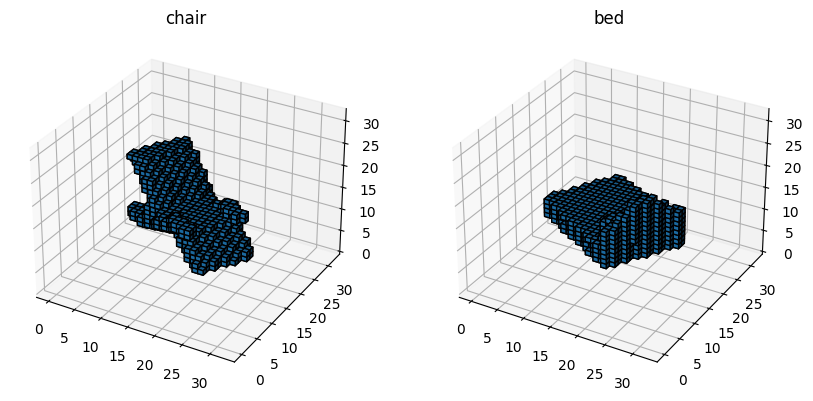

X shape :  torch.Size([32, 1, 32, 32, 32])


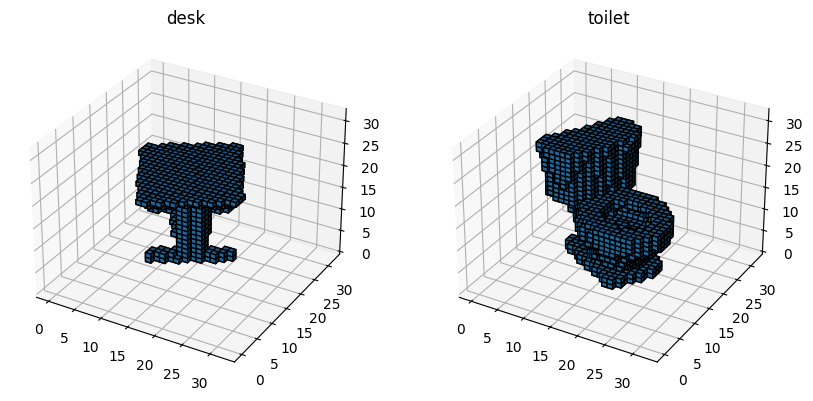

X shape :  torch.Size([32, 1, 32, 32, 32])


In [ ]:
count = 0
for x, y in train_dataloader:
    x = x.reshape(batch_size,1,volume,volume,volume)
    y = y

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.voxels(x[0][0].numpy(), edgecolor='k')
    ax.set_title(modelnet_classes[np.where(y[0] == 1)[0][0]])
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.voxels(x[1][0].numpy(), edgecolor='k')
    ax.set_title(modelnet_classes[np.where(y[1] == 1)[0][0]])
    plt.show()

    print('X shape : ',x.shape)
    count += 1
    if count > 1: break

## Network definition

In [ ]:
class VoxNet(Module):

    def __init__(self, num_categories, p_dropout=0.4, val_relu=0.1, in_channels=1, filter=32):
        super().__init__()

        self.conv = Sequential(
            # Layer 1: 3D conv(filters_num=32, filter_size=5, strides=2)
            # Input: 1@(32*32*32), Output: 32@(14*14*14)
            Conv3d(in_channels, out_channels=filter, kernel_size=5, stride=2),      # in_channels=1 <- grayscale
                                                                                    # out_channels <-> number of filters (32 for both convolutional layers)
                                                                                    # kernel_size <-> filter size
            BatchNorm3d(filter),
            LeakyReLU(val_relu),
            Dropout(p_dropout),

            # Layer 2: 3D conv(filters_num=32, filter_size=3, strides=1)
            # Input: 32@(14*14*14), Output: 32@(12x12x12)
            Conv3d(in_channels=filter, out_channels=filter, kernel_size=3, stride=1),
            BatchNorm3d(filter),
            LeakyReLU(val_relu),

            # Layer 3: Max-pooling (filter size: 2x2x2)
            # Input: 32@(12x12x12), Output: 32@(6x6x6)
            MaxPool3d(kernel_size=2, stride=2),
            Dropout(p_dropout) )

        # Flatten layer
        self.flatten = Flatten()

        # Fully Connected
        self.fc = Sequential(
            # Layer 4: Fully Connected (128 neurons)
            # Input: 1@(6*6*6)*32, Output: 1@128
            Linear(6*6*6*32, 128),
            LeakyReLU(val_relu),
            Dropout(p_dropout),

            # Layer 5: Fully Connected K class
            # Input: 1@128, Output: 1@K
            Linear(128, num_categories),
            ReLU() )

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x

## Initialization

In [ ]:
# Set random seed for reproducible results
torch.manual_seed(0)

# Network initialization
model = VoxNet(num_categories)
model.apply(weights_init)

VoxNet(
  (conv): Sequential(
    (0): Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(2, 2, 2))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.4, inplace=False)
    (4): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (5): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.4, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=6912, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=40, bias=True)
    (4): ReLU()
  )
)

### Control weight initialization

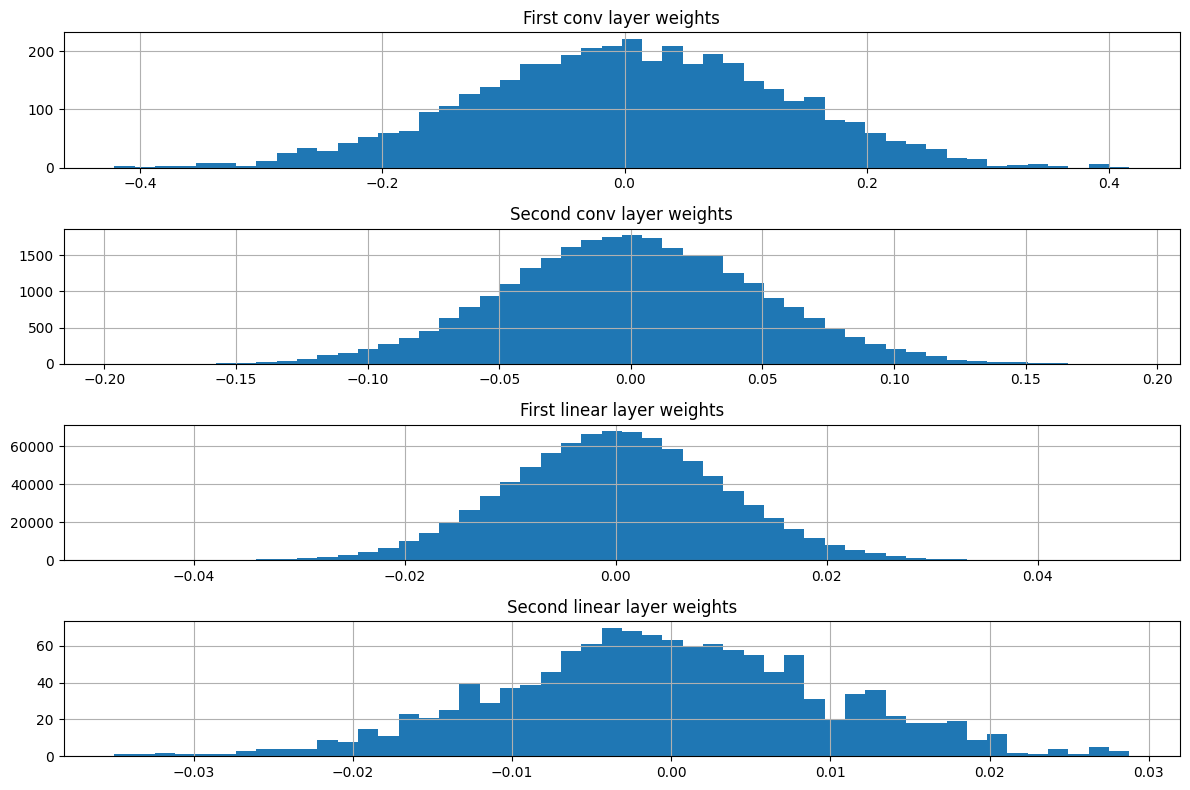

In [ ]:
h1_w = model.conv[0].weight.data.cpu().numpy()
h1_b = model.conv[0].bias.data.cpu().numpy()

h2_w = model.conv[3].weight.data.cpu().numpy()
h2_b = model.conv[3].bias.data.cpu().numpy()

h3_w = model.fc[0].weight.data.cpu().numpy()
h3_b = model.fc[0].bias.data.cpu().numpy()

h4_w = model.fc[3].weight.data.cpu().numpy()
h4_b = model.fc[3].bias.data.cpu().numpy()

# Weights histogram
fig, axs = plt.subplots(4, 1, figsize=(12,8))
axs[0].hist(h1_w.flatten(), 50)
axs[0].set_title('First conv layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second conv layer weights')
axs[2].hist(h3_w.flatten(), 50)
axs[2].set_title('First linear layer weights')
axs[3].hist(h4_w.flatten(), 50)
axs[3].set_title('Second linear layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

In [ ]:
# bias
print(h1_b)
print(h2_b)
print(h3_b)
print(h4_b)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## Training

Set hyperparameters, optimizer and loss function

In [ ]:
epochs = 30
learning_rate = 0.001
optimizer_weight_decay = 0.001

loss_fn = CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=optimizer_weight_decay)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=optimizer_momentum, weight_decay=optimizer_weight_decay) #SGD with momentum and L2 regularization
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma) #learning rate decreases by a factor 10 each 40000 batches

save_parameters, save_folder = True, '/content/drive/My Drive/Dataset/Saved_parameters/'  #'/content/drive/My Drive/Progetto Andrea/' #'/content/drive/My Drive/Dataset/Saved_parameters/'

Connect to **Weight and Biases** to visualise the training procedure

In [ ]:
wandb.init(project='Voxnet - final tests',
           entity='nndl',
           config={
            "model": model,
            "batch size": batch_size,
            "epochs": epochs,
            "learning rate": learning_rate,
            "weight decay": optimizer_weight_decay,
            "loss": loss_fn
            })
wandb.watch(model, loss_fn, log="all")

[]

Train the VoxNet architecture

del statements are useful to free the memory during training. In this way, we prevent that all the dataset and the results of the network are stored in memory when not needed.

In [ ]:
start = time()

model.to(device)
best_val = np.inf

for epoch in range(epochs):
    print(f"Epoch: {epoch+1}")
    model.train()
    train_loss= []
    iterator = tqdm(train_dataloader)

    for batch_x, batch_y in iterator:
        batch_x = batch_x.reshape(batch_size,1,volume,volume,volume).to(device).float()
        batch_y = batch_y.to(device).float()

        y_pred = model(batch_x)
        loss = loss_fn(y_pred, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Save train loss for this batch
        train_loss.append(loss.detach().cpu().numpy())
        del batch_x, batch_y, y_pred, loss

    # Average train loss
    train_loss = np.mean(train_loss)
    print(f"Train loss: {train_loss}")

    model.eval()
    with torch.no_grad():
        predictions = []
        labels = []
        for batch_x, batch_y in tqdm(val_dataloader):
            data_shape = batch_x.shape
            batch_x = batch_x.reshape(data_shape[0],1,volume,volume,volume).to(device).float()
            batch_y = batch_y.to(device).float()

            y_pred = model(batch_x)

            predictions.append(y_pred)
            labels.append(batch_y)

            del batch_x, batch_y, y_pred

        predictions = torch.cat(predictions, axis=0)
        labels = torch.cat(labels, axis=0)

        # Evaluate validation loss and accuracy
        val_loss = loss_fn(predictions, labels)
        val_loss = val_loss.detach().cpu().numpy()
        val_acc = accuracy_score(labels.detach().cpu().numpy().argmax(axis=1), predictions.softmax(axis=1).detach().cpu().numpy().argmax(axis=1))
        print(f"Validation loss: {val_loss}, accuracy: {val_acc}")

    wandb.log({'epoch': epoch+1, 'train_loss': train_loss, 'val_loss': val_loss, 'accuracy': val_acc})

    if val_loss < best_val and save_parameters:
        best_val = val_loss

        # Save network parameters
        torch.save(model.state_dict(), save_folder+"Voxnet_parameters.torch")
        # Save the optimizer state
        torch.save(optimizer.state_dict(), save_folder+"Voxnet_optimizer_state.torch")

end = time()
print(f'Execution time = {end-start} s')

Epoch: 1


100%|██████████| 1197/1197 [00:20<00:00, 57.94it/s]


Train loss: 0.7345768213272095


100%|██████████| 300/300 [00:02<00:00, 126.62it/s]


Validation loss: 0.3425903916358948, accuracy: 0.9047619047619048
Epoch: 2


100%|██████████| 1197/1197 [00:19<00:00, 60.67it/s]


Train loss: 0.3391217589378357


100%|██████████| 300/300 [00:01<00:00, 152.89it/s]


Validation loss: 0.28803306818008423, accuracy: 0.906328320802005
Epoch: 3


100%|██████████| 1197/1197 [00:21<00:00, 56.02it/s]


Train loss: 0.2378726601600647


100%|██████████| 300/300 [00:01<00:00, 159.60it/s]


Validation loss: 0.23906341195106506, accuracy: 0.9218880534670009
Epoch: 4


100%|██████████| 1197/1197 [00:19<00:00, 60.20it/s]


Train loss: 0.2127242386341095


100%|██████████| 300/300 [00:01<00:00, 156.84it/s]


Validation loss: 0.2327864021062851, accuracy: 0.9296157059314955
Epoch: 5


100%|██████████| 1197/1197 [00:20<00:00, 57.78it/s]


Train loss: 0.1952584981918335


100%|██████████| 300/300 [00:01<00:00, 155.08it/s]


Validation loss: 0.2134561538696289, accuracy: 0.9346282372598163
Epoch: 6


100%|██████████| 1197/1197 [00:20<00:00, 59.00it/s]


Train loss: 0.1789211481809616


100%|██████████| 300/300 [00:02<00:00, 132.70it/s]


Validation loss: 0.21827860176563263, accuracy: 0.9293024227234754
Epoch: 7


100%|██████████| 1197/1197 [00:20<00:00, 59.03it/s]


Train loss: 0.17670932412147522


100%|██████████| 300/300 [00:01<00:00, 154.16it/s]


Validation loss: 0.19506321847438812, accuracy: 0.9372389306599833
Epoch: 8


100%|██████████| 1197/1197 [00:20<00:00, 59.62it/s]


Train loss: 0.16853642463684082


100%|██████████| 300/300 [00:02<00:00, 116.52it/s]


Validation loss: 0.20747806131839752, accuracy: 0.9315998329156224
Epoch: 9


100%|██████████| 1197/1197 [00:20<00:00, 59.02it/s]


Train loss: 0.16321183741092682


100%|██████████| 300/300 [00:01<00:00, 152.84it/s]


Validation loss: 0.20883813500404358, accuracy: 0.935672514619883
Epoch: 10


100%|██████████| 1197/1197 [00:19<00:00, 59.98it/s]


Train loss: 0.16060073673725128


100%|██████████| 300/300 [00:02<00:00, 117.55it/s]


Validation loss: 0.18990576267242432, accuracy: 0.9358813700918964
Epoch: 11


100%|██████████| 1197/1197 [00:20<00:00, 59.41it/s]


Train loss: 0.15827888250350952


100%|██████████| 300/300 [00:01<00:00, 150.12it/s]


Validation loss: 0.18590286374092102, accuracy: 0.9370300751879699
Epoch: 12


100%|██████████| 1197/1197 [00:20<00:00, 59.46it/s]


Train loss: 0.15574711561203003


100%|██████████| 300/300 [00:02<00:00, 109.15it/s]


Validation loss: 0.18833006918430328, accuracy: 0.9387009189640768
Epoch: 13


100%|██████████| 1197/1197 [00:21<00:00, 55.90it/s]


Train loss: 0.14898447692394257


100%|██████████| 300/300 [00:01<00:00, 155.09it/s]


Validation loss: 0.20260141789913177, accuracy: 0.9309732664995823
Epoch: 14


100%|██████████| 1197/1197 [00:19<00:00, 60.29it/s]


Train loss: 0.150083988904953


100%|██████████| 300/300 [00:02<00:00, 112.97it/s]


Validation loss: 0.1974630355834961, accuracy: 0.9384920634920635
Epoch: 15


100%|██████████| 1197/1197 [00:20<00:00, 59.79it/s]


Train loss: 0.14314240217208862


100%|██████████| 300/300 [00:01<00:00, 153.41it/s]


Validation loss: 0.1965315043926239, accuracy: 0.9379699248120301
Epoch: 16


100%|██████████| 1197/1197 [00:20<00:00, 59.83it/s]


Train loss: 0.14834018051624298


100%|██████████| 300/300 [00:02<00:00, 112.88it/s]


Validation loss: 0.19148647785186768, accuracy: 0.9372389306599833
Epoch: 17


100%|██████████| 1197/1197 [00:19<00:00, 60.28it/s]


Train loss: 0.1436290293931961


100%|██████████| 300/300 [00:01<00:00, 153.89it/s]


Validation loss: 0.20114541053771973, accuracy: 0.9332706766917294
Epoch: 18


100%|██████████| 1197/1197 [00:20<00:00, 59.39it/s]


Train loss: 0.1420517861843109


100%|██████████| 300/300 [00:02<00:00, 123.08it/s]


Validation loss: 0.19545017182826996, accuracy: 0.9328529657477026
Epoch: 19


100%|██████████| 1197/1197 [00:19<00:00, 60.72it/s]


Train loss: 0.14335426688194275


100%|██████████| 300/300 [00:01<00:00, 156.31it/s]


Validation loss: 0.20900283753871918, accuracy: 0.9341060985797828
Epoch: 20


100%|██████████| 1197/1197 [00:20<00:00, 59.59it/s]


Train loss: 0.13760493695735931


100%|██████████| 300/300 [00:02<00:00, 130.17it/s]


Validation loss: 0.21304123103618622, accuracy: 0.9284670008354219
Epoch: 21


100%|██████████| 1197/1197 [00:19<00:00, 60.52it/s]


Train loss: 0.14236539602279663


100%|██████████| 300/300 [00:01<00:00, 158.14it/s]


Validation loss: 0.19970853626728058, accuracy: 0.9325396825396826
Epoch: 22


100%|██████████| 1197/1197 [00:20<00:00, 59.08it/s]


Train loss: 0.14053790271282196


100%|██████████| 300/300 [00:02<00:00, 135.81it/s]


Validation loss: 0.18592628836631775, accuracy: 0.9359857978279031
Epoch: 23


100%|██████████| 1197/1197 [00:20<00:00, 59.13it/s]


Train loss: 0.13555893301963806


100%|██████████| 300/300 [00:02<00:00, 126.28it/s]


Validation loss: 0.19169266521930695, accuracy: 0.9365079365079365
Epoch: 24


100%|██████████| 1197/1197 [00:20<00:00, 58.60it/s]


Train loss: 0.13821975886821747


100%|██████████| 300/300 [00:01<00:00, 151.04it/s]


Validation loss: 0.18327468633651733, accuracy: 0.9423558897243107
Epoch: 25


100%|██████████| 1197/1197 [00:20<00:00, 59.76it/s]


Train loss: 0.14010494947433472


100%|██████████| 300/300 [00:02<00:00, 138.91it/s]


Validation loss: 0.21896497905254364, accuracy: 0.9312865497076024
Epoch: 26


100%|██████████| 1197/1197 [00:20<00:00, 58.55it/s]


Train loss: 0.1376364380121231


100%|██████████| 300/300 [00:01<00:00, 152.91it/s]


Validation loss: 0.20623062551021576, accuracy: 0.9345238095238095
Epoch: 27


100%|██████████| 1197/1197 [00:19<00:00, 60.27it/s]


Train loss: 0.136368989944458


100%|██████████| 300/300 [00:02<00:00, 133.25it/s]


Validation loss: 0.18023523688316345, accuracy: 0.9403717627401837
Epoch: 28


100%|██████████| 1197/1197 [00:20<00:00, 58.89it/s]


Train loss: 0.1348642110824585


100%|██████████| 300/300 [00:01<00:00, 151.87it/s]


Validation loss: 0.19150619208812714, accuracy: 0.9304511278195489
Epoch: 29


100%|██████████| 1197/1197 [00:19<00:00, 60.18it/s]


Train loss: 0.13235166668891907


100%|██████████| 300/300 [00:02<00:00, 118.68it/s]


Validation loss: 0.17909500002861023, accuracy: 0.9426691729323309
Epoch: 30


100%|██████████| 1197/1197 [00:20<00:00, 59.07it/s]


Train loss: 0.13485552370548248


100%|██████████| 300/300 [00:01<00:00, 154.84it/s]

Validation loss: 0.20801806449890137, accuracy: 0.9320175438596491
Execution time = 672.9126691818237 s


In [ ]:
wandb.finish()

accuracy,▁▁▄▆▇▆▇▆▇▇▇▇▆▇▇▇▆▆▆▅▆▇▇█▆▆█▆█▆
epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▃▂▃▂▂▂▁▁▁▂▂▂▂▂▂▂▂▂▁▂▁▃▂▁▂▁▂
accuracy,0.93202
epoch,30
train_loss,0.13486
val_loss,0.20802


## Metrics on validation set

In [ ]:
model.eval()
model.to(device)
with torch.no_grad():
    predictions = []
    labels = []
    for batch_x, batch_y in tqdm(val_dataloader):
        data_shape = batch_x.shape
        batch_x = batch_x.reshape(data_shape[0],1,volume,volume,volume).to(device).float()
        batch_y = batch_y.to(device).float()

        y_pred = model(batch_x)

        predictions.append(y_pred)
        labels.append(batch_y)

        del batch_x, batch_y, y_pred

predictions = torch.cat(predictions, axis=0).softmax(axis=1).detach().cpu().argmax(axis=1)
labels = torch.cat(labels, axis=0).detach().cpu().argmax(axis=1)

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:14<00:00, 20.45it/s]



CONFUSION MATRIX


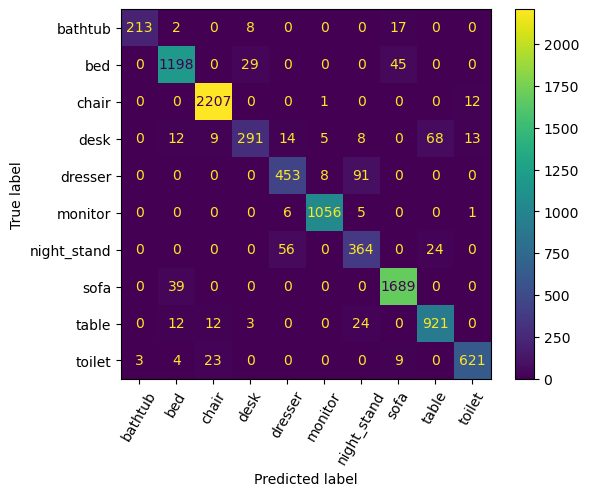


ACCURACY
Micro (global) accuracy: 0.9412071704864502
Macro accuracy: 0.9011430740356445
Accuracy for each class
	 bathtub :  0.8875
	 bed :  0.9418239
	 chair :  0.99414414
	 desk :  0.69285715
	 dresser :  0.8206522
	 monitor :  0.98876405
	 night_stand :  0.8198198
	 sofa :  0.9774306
	 table :  0.94753087
	 toilet :  0.9409091


In [ ]:
metrics(predictions, labels, modelnet_classes, macro=True, each=True, weighted=False, F1=False)

## Metrics on test set

In [ ]:
model.eval()
with torch.no_grad():
    predictions, labels, predictions_vot, labels_vot = [], [], [], []
    for batch_x, batch_y in tqdm(test_dataloader):
        batch_x = batch_x.reshape(12,1,volume,volume,volume).to(device).float()
        batch_y = batch_y.to(device).float()

        y_pred = model(batch_x)

        predictions.append(y_pred)
        labels.append(batch_y)

        y_pred = torch.sum(y_pred.softmax(axis=1), 0)
        predictions_vot.append(y_pred.detach().cpu().numpy().argmax())
        labels_vot.append(batch_y[0].detach().cpu().numpy().argmax())

        del batch_x, batch_y, y_pred

predictions = torch.cat(predictions, axis=0).softmax(axis=1).detach().cpu().argmax(axis=1)
labels = torch.cat(labels, axis=0).detach().cpu().argmax(axis=1)

print(f'\n Accuracy (vanilla) = {accuracy_score(labels,predictions)*100:.2f} %')
print(f'\n Accuracy (voting) = {accuracy_score(labels_vot,predictions_vot)*100:.2f} %')

100%|████████████████████████████████████████████████████████████████████████████████| 908/908 [00:17<00:00, 50.82it/s]


 Accuracy (vanilla) = 89.96 %

 Accuracy (voting) = 90.53 %


### Metrics without voting


CONFUSION MATRIX


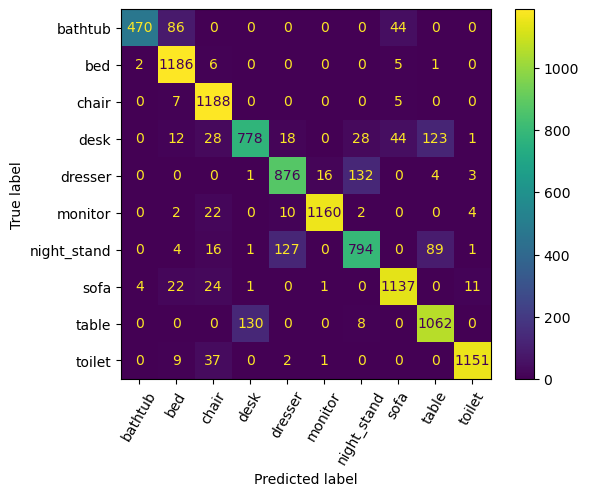


ACCURACY
Micro (global) accuracy: 0.8995961546897888
Accuracy for each class
	 bathtub :  0.78333336
	 bed :  0.98833334
	 chair :  0.99
	 desk :  0.753876
	 dresser :  0.8488372
	 monitor :  0.96666664
	 night_stand :  0.76937985
	 sofa :  0.9475
	 table :  0.885
	 toilet :  0.95916665


In [ ]:
metrics(predictions, labels, modelnet_classes, macro=False, each=True, weighted=False, F1=False)

### Metrics with voting


CONFUSION MATRIX


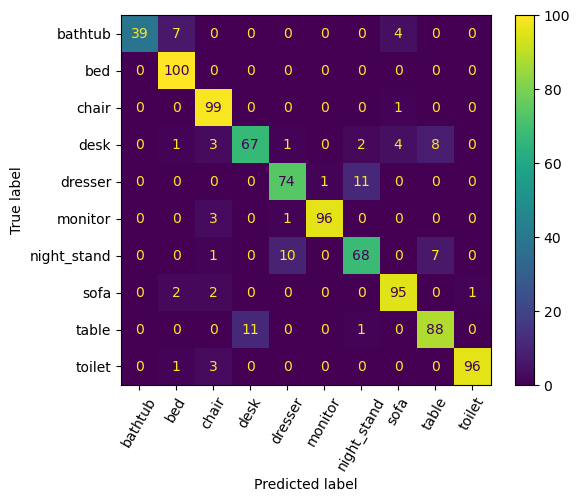


ACCURACY
Micro (global) accuracy: 0.9052863717079163
Macro accuracy: 0.8950232267379761


In [ ]:
predictions_vot = torch.tensor(predictions_vot)
labels_vot = torch.tensor(labels_vot)

metrics(predictions_vot, labels_vot, modelnet_classes, macro=True, each=False, weighted=False, F1=False)

## Reload saved network

Load files to continue training

In [ ]:
### Reload the network state
net_state_dict = torch.load('net_parameters.torch')
# Update the network parameters
model.load_state_dict(net_state_dict)

# Reload the optimizer state
opt_state_dict = torch.load('optimizer_state.torch')
optimizer.load_state_dict(opt_state_dict)

# Reload the scheduler state
#scheduler_state_dict = torch.load('scheduler_state.torch')
#scheduler.load_state_dict(scheduler_state_dict)

Load trained architecture

In [ ]:
#net_state_dict = torch.load('/content/drive/My Drive/Dataset/Saved_parameters/Voxnet_parameters_Valian_wind__epoch25.torch')
net_state_dict = torch.load('Saved params/Final VoxNet & Orion/Voxnet_parameters_Sage_gorge__epoch28.torch', map_location=torch.device('cpu'))

model = VoxNet(num_categories).to(device)
model.load_state_dict(net_state_dict)

<All keys matched successfully>

# ORION

## Load dataset

In [ ]:
#drive.mount('/content/drive')

transforms = Compose([
    RandomShift(translate_range = [-2,2]),
    RandomNoise(noise_level = 0.05)
])

use_poseplan = True

train_set = ThreeD_Dataset(dataset_path, 'train', num_categories, True, use_poseplan, transform=transforms)
val_set = ThreeD_Dataset(dataset_path, 'val', num_categories, True, use_poseplan)
test_set = ThreeD_Dataset(dataset_path, 'test', num_categories, True, use_poseplan)

In [ ]:
batch_size = 32

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size)
test_dataloader = DataLoader(test_set, batch_size=12)

Visualise samples from training set

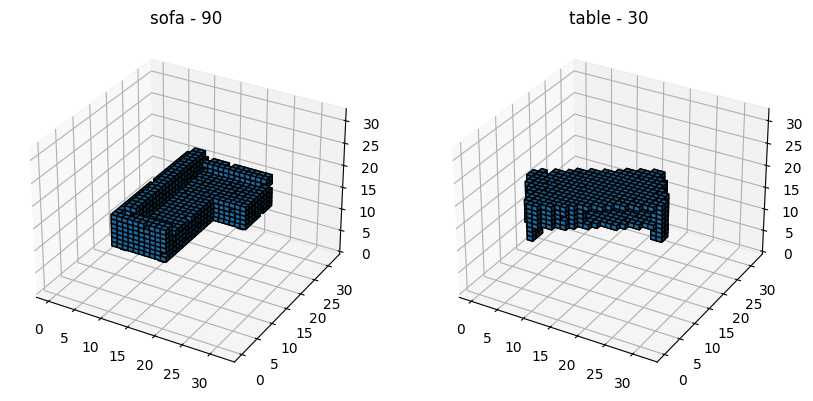

X shape :  torch.Size([32, 1, 32, 32, 32])


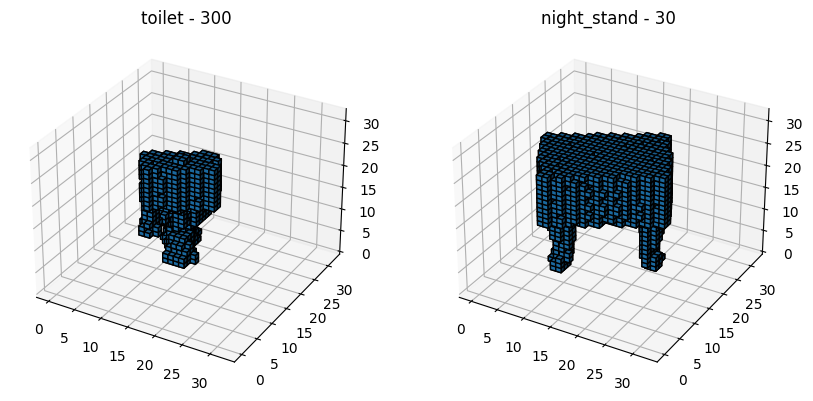

X shape :  torch.Size([32, 1, 32, 32, 32])


In [ ]:
count = 0
for x, y, rot in train_dataloader:
    x = x.reshape(batch_size,1,volume,volume,volume)
    y = y

    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.voxels(x[0][0].numpy(), edgecolor='k')
    ax.set_title(str(modelnet_classes[np.where(y[0] == 1)[0][0]])+' - '+str(np.where(rot[0] == 1)[0][0]*30))
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.voxels(x[1][0].numpy(), edgecolor='k')
    ax.set_title(str(modelnet_classes[np.where(y[1] == 1)[0][0]])+' - '+str(np.where(rot[1] == 1)[0][0]*30))
    plt.show()

    print('X shape : ',x.shape)
    count += 1
    if count > 1: break

## Network definition

In [ ]:
class ORION(Module):

    def __init__(self, num_categories, num_rotations, p_dropout=0.4, val_relu=0.1, in_channels=1, filter=32):
        super().__init__()

        self.conv = Sequential(
            # Layer 1: 3D conv(filters_num=32, filter_size=5, strides=2)
            # Input: 1@(32*32*32), Output: 32@(14*14*14)
            Conv3d(in_channels, out_channels=filter, kernel_size=5, stride=2),
            BatchNorm3d(filter),
            LeakyReLU(val_relu),
            Dropout(p_dropout),

            # Layer 2: 3D conv(filters_num=32, filte_size=3, strides=1)
            # Input: 32@(14*14*14), Output: 32@(12x12x12)
            Conv3d(in_channels=filter, out_channels=filter, kernel_size=3, stride=1),
            BatchNorm3d(filter),
            LeakyReLU(val_relu),

            # Layer 3: Max-pooling (filter size: 2x2x2)
            # Input: 32@(12x12x12), Output: 32@(6x6x6)
            MaxPool3d(kernel_size=2, stride=2),
            Dropout(p_dropout) )


        # Flatten layer
        self.flatten = Flatten()

        # Fully Connected
        self.fc = Sequential(
            # Layer 4: Fully Connected 128
            # Input: 1@(6*6*6)*32, Output: 1@128
            Linear(6*6*6*32, 128),
            LeakyReLU(val_relu),
            Dropout(p_dropout),

            # Layer 5: Fully Connected K class each with num_rotations[i] possible alignments
            # Input: 1@128, Output: 1@K+sum(num_rotations)
            Linear(128, num_categories + num_rotations.sum()),
            ReLU() )


    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

## Initialization

In [ ]:
# Set random seed for reproducible results
torch.manual_seed(0)

# Network initialization
if use_poseplan:
    num_rotations = poseplan
else:
    num_rotations = np.repeat(12, num_categories)

model = ORION(num_categories, num_rotations)
model.apply(weights_init) #same weight initialization as for VoxNet

ORION(
  (conv): Sequential(
    (0): Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(2, 2, 2))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.1)
    (3): Dropout(p=0.4, inplace=False)
    (4): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (5): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.1)
    (7): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout(p=0.4, inplace=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Sequential(
    (0): Linear(in_features=6912, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=128, out_features=130, bias=True)
    (4): ReLU()
  )
)

## Training

Set hyperparameters, optimizer and loss function

In [ ]:
epochs = 60
learning_rate = 0.001
optimizer_weight_decay = 0.001

loss_cat, loss_rot = CrossEntropyLoss(), CrossEntropyLoss()
gamma_loss = 0.5

def loss_total(cat, rot, gamma):
    return (1-gamma)*cat + gamma*rot

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=optimizer_weight_decay)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=optimizer_momentum, weight_decay=optimizer_weight_decay) #SGD with momentum and L2 regularization
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma) #learning rate decreases by a factor 10 each 40000 batches

save_parameters, save_folder = True, '/content/drive/My Drive/Dataset/Saved_parameters/'  #'/content/drive/My Drive/Progetto Andrea/' #'/content/drive/My Drive/Dataset/Saved_parameters/' # 'Saved_params/'

Connect to **Weight and Biases** to visualise the training procedure

In [ ]:
wandb.init(project='Andrea - Orion final tests',
           entity='nndl',
           config={
            "model": model,
            "batch size": batch_size,
            "epochs": epochs,
            "learning rate": learning_rate,
            "weight decay": optimizer_weight_decay,
            "loss gamma": gamma_loss
            })
wandb.watch(model, log="all")

accuracy,▃▂▅▇▅▃▅▂▁▃▅▅█▆▂▅▂▂▅▅
accuracy_rot,▃▂▅▇▆▅▆▁▂▄▆▅▆█▂▃▄▁▅▅
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▅▅▂▃▃▃▄▂▃▄▄▄▃▁▄▁▂▂▄
train_loss_cat,█▆▅▃▃▂▄▄▁▄▄▄▄▁▂▄▁▂▂▅
train_loss_rot,█▅▅▃▃▄▃▄▃▂▅▄▄▄▁▃▂▃▃▃
val_loss,▆█▃▁▅▅▃▅▅▅▃▃▁▄▆▅▅█▂▄
val_loss_cat,▅▇▃▁▅▅▃▄▅▅▂▃▁▅▆▄▆█▂▃
val_loss_rot,▇█▄▁▅▅▃▅▄▅▃▃▁▃▇▆▅█▁▅
accuracy,0.94215
accuracy_rot,0.90508


[]

Train the Orion architecture

In [ ]:
model.to(device)
best_val = np.inf
for epoch in range(epochs):
    print(f"Epoch: {epoch+1}")
    model.train()
    train_loss, train_loss_cat, train_loss_rot = [], [], []

    iterator = tqdm(train_dataloader)
    for batch_x, batch_y, batch_rot in iterator:
        batch_x = batch_x.reshape(batch_size,1,volume,volume,volume).to(device).float()
        batch_y = batch_y.to(device).float()
        batch_rot = batch_rot.to(device).float()

        y_pred = model(batch_x)

        y_pred_cat = y_pred[:,:num_categories]
        lossc = loss_cat(y_pred_cat, batch_y)
        class_ = batch_y.detach().cpu().numpy().argmax(axis=1)

        y_pred_rot = y_pred[:,num_categories:]
        batch_rot_eff = torch.zeros((batch_size,num_rotations.sum())).to(device)
        for i in range(batch_size):
            batch_rot_eff[i, sum(num_rotations[:class_[i]]) : sum(num_rotations[:class_[i]]) + num_rotations[class_[i]]] = batch_rot[i,:num_rotations[class_[i]]]
        batch_rot = batch_rot_eff
        del batch_rot_eff

        lossr = loss_rot(y_pred_rot, batch_rot)
        loss = loss_total(lossc, lossr, gamma_loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()

        # Save train loss for this batch
        train_loss.append(loss.detach().cpu().numpy())
        train_loss_cat.append(lossc.detach().cpu().numpy())
        train_loss_rot.append(lossr.detach().cpu().numpy())

        del batch_x, batch_y, batch_rot, y_pred, y_pred_cat, lossc, class_, y_pred_rot, lossr, loss

    # Average train loss
    train_loss, train_loss_cat, train_loss_rot = np.mean(train_loss), np.mean(train_loss_cat), np.mean(train_loss_rot)
    print(f"Train loss: {train_loss}")
    #print(f"category: {train_loss_cat}")
    #print(f"alignment: {train_loss_rot}")

    model.eval()
    with torch.no_grad():
        predictions_cat, predictions_rot, labels_cat, labels_rot = [], [], [], []
        for batch_x, batch_y, batch_rot in tqdm(val_dataloader):
            data_shape = batch_x.shape
            batch_x = batch_x.reshape(data_shape[0],1,volume,volume,volume).to(device).float()
            batch_y = batch_y.to(device).float()
            batch_rot = batch_rot.to(device).float()

            y_pred = model(batch_x)

            y_pred_cat = y_pred[:,:num_categories]
            predictions_cat.append(y_pred_cat)
            class_ = batch_y.detach().cpu().numpy().argmax(axis=1)

            y_pred_rot = y_pred[:,num_categories:]
            batch_rot_eff = torch.zeros((data_shape[0],num_rotations.sum())).to(device)
            for i in range(data_shape[0]):
                batch_rot_eff[i, sum(num_rotations[:class_[i]]) : sum(num_rotations[:class_[i]]) + num_rotations[class_[i]]] = batch_rot[i,:num_rotations[class_[i]]]
            batch_rot = batch_rot_eff
            del batch_rot_eff

            labels_cat.append(batch_y)
            labels_rot.append(batch_rot)
            predictions_rot.append(y_pred_rot)

            del batch_x, batch_y, batch_rot, y_pred, y_pred_cat, class_, y_pred_rot

        predictions_cat = torch.cat(predictions_cat, axis=0)
        predictions_rot = torch.cat(predictions_rot, axis=0)
        labels_cat = torch.cat(labels_cat, axis=0)
        labels_rot = torch.cat(labels_rot, axis=0)

        # Evaluate validation loss and accuracy
        val_loss_cat = loss_cat(predictions_cat, labels_cat)
        val_loss_rot = loss_rot(predictions_rot, labels_rot)
        val_loss = loss_total(val_loss_cat, val_loss_rot, gamma_loss)

        val_loss = val_loss.detach().cpu().numpy()
        val_acc_cat = accuracy_score(labels_cat.detach().cpu().numpy().argmax(axis=1), predictions_cat.softmax(axis=1).detach().cpu().numpy().argmax(axis=1))
        val_acc_rot = accuracy_score(labels_rot.detach().cpu().numpy().argmax(axis=1), predictions_rot.softmax(axis=1).detach().cpu().numpy().argmax(axis=1))
        print(f"Validation loss: {val_loss}, accuracy: {val_acc_cat}, accuracy rot: {val_acc_rot}")
        #print(f"category loss: {val_loss_cat}")
        #print(f"alignment loss: {val_loss_rot}")

    wandb.log({'epoch': epoch+1, 'train_loss': train_loss, 'train_loss_cat': train_loss_cat, 'train_loss_rot': train_loss_rot,
              'val_loss': val_loss, 'val_loss_cat': val_loss_cat, 'val_loss_rot': val_loss_rot, 'accuracy': val_acc_cat, 'accuracy_rot': val_acc_rot})

    if val_loss < best_val and save_parameters:
        best_val = val_loss

        # Save network parameters
        torch.save(model.state_dict(), save_folder+"Orion_parameters.torch")
        # Save the optimizer state
        torch.save(optimizer.state_dict(), save_folder+"Orion_optimizer_state.torch")
        # Save the scheduler state
        #torch.save(scheduler.state_dict(), save_folder+"scheduler_state.torch")

Epoch: 1


100%|██████████| 1197/1197 [00:57<00:00, 20.80it/s]


Train loss: 1.8529125452041626


100%|██████████| 300/300 [00:03<00:00, 79.29it/s]


Validation loss: 1.2926608324050903, accuracy: 0.9031954887218046, accuracy rot: 0.48454469507101083
Epoch: 2


100%|██████████| 1197/1197 [00:59<00:00, 19.96it/s]


Train loss: 1.0187737941741943


100%|██████████| 300/300 [00:04<00:00, 60.57it/s]


Validation loss: 0.6390005946159363, accuracy: 0.9247076023391813, accuracy rot: 0.741750208855472
Epoch: 3


100%|██████████| 1197/1197 [00:56<00:00, 21.30it/s]


Train loss: 0.5772568583488464


100%|██████████| 300/300 [00:04<00:00, 67.49it/s]


Validation loss: 0.44041386246681213, accuracy: 0.9249164578111947, accuracy rot: 0.8190267335004177
Epoch: 4


100%|██████████| 1197/1197 [00:56<00:00, 21.25it/s]


Train loss: 0.4524140954017639


100%|██████████| 300/300 [00:04<00:00, 73.77it/s]


Validation loss: 0.3583899438381195, accuracy: 0.9256474519632414, accuracy rot: 0.8474310776942355
Epoch: 5


100%|██████████| 1197/1197 [00:56<00:00, 21.06it/s]


Train loss: 0.34260520339012146


100%|██████████| 300/300 [00:03<00:00, 80.32it/s]


Validation loss: 0.26869791746139526, accuracy: 0.9306599832915622, accuracy rot: 0.8909774436090225
Epoch: 6


100%|██████████| 1197/1197 [00:56<00:00, 21.11it/s]


Train loss: 0.31251177191734314


100%|██████████| 300/300 [00:03<00:00, 79.43it/s]


Validation loss: 0.2696186304092407, accuracy: 0.9320175438596491, accuracy rot: 0.8849206349206349
Epoch: 7


100%|██████████| 1197/1197 [00:56<00:00, 21.18it/s]


Train loss: 0.3031180202960968


100%|██████████| 300/300 [00:03<00:00, 78.79it/s]


Validation loss: 0.25854161381721497, accuracy: 0.9307644110275689, accuracy rot: 0.891499582289056
Epoch: 8


100%|██████████| 1197/1197 [00:56<00:00, 21.04it/s]


Train loss: 0.29349538683891296


100%|██████████| 300/300 [00:03<00:00, 77.93it/s]


Validation loss: 0.2639288902282715, accuracy: 0.9365079365079365, accuracy rot: 0.8906641604010025
Epoch: 9


100%|██████████| 1197/1197 [00:56<00:00, 21.07it/s]


Train loss: 0.28791552782058716


100%|██████████| 300/300 [00:04<00:00, 73.02it/s]


Validation loss: 0.2519639730453491, accuracy: 0.934001670843776, accuracy rot: 0.8941102756892231
Epoch: 10


100%|██████████| 1197/1197 [00:56<00:00, 21.32it/s]


Train loss: 0.28020915389060974


100%|██████████| 300/300 [00:04<00:00, 68.19it/s]


Validation loss: 0.25495222210884094, accuracy: 0.9373433583959899, accuracy rot: 0.8942147034252298
Epoch: 11


100%|██████████| 1197/1197 [00:55<00:00, 21.44it/s]


Train loss: 0.27916139364242554


100%|██████████| 300/300 [00:04<00:00, 62.32it/s]


Validation loss: 0.25356876850128174, accuracy: 0.9315998329156224, accuracy rot: 0.8959899749373433
Epoch: 12


100%|██████████| 1197/1197 [00:56<00:00, 21.35it/s]


Train loss: 0.27672427892684937


100%|██████████| 300/300 [00:04<00:00, 67.86it/s]


Validation loss: 0.2390626221895218, accuracy: 0.9370300751879699, accuracy rot: 0.8959899749373433
Epoch: 13


100%|██████████| 1197/1197 [00:56<00:00, 21.09it/s]


Train loss: 0.2781447470188141


100%|██████████| 300/300 [00:03<00:00, 76.58it/s]


Validation loss: 0.2463606894016266, accuracy: 0.9382832080200502, accuracy rot: 0.8972431077694235
Epoch: 14


100%|██████████| 1197/1197 [00:56<00:00, 21.13it/s]


Train loss: 0.2721227705478668


100%|██████████| 300/300 [00:03<00:00, 80.97it/s]


Validation loss: 0.2656175196170807, accuracy: 0.9278404344193818, accuracy rot: 0.891499582289056
Epoch: 15


100%|██████████| 1197/1197 [00:57<00:00, 20.92it/s]


Train loss: 0.2688177525997162


100%|██████████| 300/300 [00:03<00:00, 77.56it/s]


Validation loss: 0.2762584686279297, accuracy: 0.9296157059314955, accuracy rot: 0.8943191311612364
Epoch: 16


100%|██████████| 1197/1197 [00:57<00:00, 20.99it/s]


Train loss: 0.2685023248195648


100%|██████████| 300/300 [00:03<00:00, 80.67it/s]


Validation loss: 0.2459673285484314, accuracy: 0.9401629072681704, accuracy rot: 0.8984962406015038
Epoch: 17


100%|██████████| 1197/1197 [00:56<00:00, 21.14it/s]


Train loss: 0.26567715406417847


100%|██████████| 300/300 [00:03<00:00, 79.73it/s]


Validation loss: 0.23974040150642395, accuracy: 0.9400584795321637, accuracy rot: 0.8976608187134503
Epoch: 18


100%|██████████| 1197/1197 [00:55<00:00, 21.40it/s]


Train loss: 0.26528728008270264


100%|██████████| 300/300 [00:03<00:00, 75.05it/s]


Validation loss: 0.2565751075744629, accuracy: 0.9390142021720969, accuracy rot: 0.8949456975772765
Epoch: 19


100%|██████████| 1197/1197 [00:55<00:00, 21.54it/s]


Train loss: 0.26677319407463074


100%|██████████| 300/300 [00:04<00:00, 72.31it/s]


Validation loss: 0.23935991525650024, accuracy: 0.9394319131161236, accuracy rot: 0.8973475355054302
Epoch: 20


100%|██████████| 1197/1197 [00:55<00:00, 21.53it/s]


Train loss: 0.262243390083313


100%|██████████| 300/300 [00:04<00:00, 67.77it/s]


Validation loss: 0.24379411339759827, accuracy: 0.9373433583959899, accuracy rot: 0.8991228070175439
Epoch: 21


100%|██████████| 1197/1197 [00:55<00:00, 21.74it/s]


Train loss: 0.2646673619747162


100%|██████████| 300/300 [00:04<00:00, 65.31it/s]


Validation loss: 0.24897193908691406, accuracy: 0.9350459482038429, accuracy rot: 0.8942147034252298
Epoch: 22


100%|██████████| 1197/1197 [00:54<00:00, 21.90it/s]


Train loss: 0.26483869552612305


100%|██████████| 300/300 [00:04<00:00, 62.97it/s]


Validation loss: 0.23254546523094177, accuracy: 0.9437134502923976, accuracy rot: 0.902360066833751
Epoch: 23


100%|██████████| 1197/1197 [00:54<00:00, 21.98it/s]


Train loss: 0.26266223192214966


100%|██████████| 300/300 [00:04<00:00, 63.35it/s]


Validation loss: 0.2361678183078766, accuracy: 0.9404761904761905, accuracy rot: 0.8971386800334169
Epoch: 24


100%|██████████| 1197/1197 [00:55<00:00, 21.50it/s]


Train loss: 0.2609925866127014


100%|██████████| 300/300 [00:04<00:00, 64.42it/s]


Validation loss: 0.24744166433811188, accuracy: 0.9387009189640768, accuracy rot: 0.9011069340016709
Epoch: 25


100%|██████████| 1197/1197 [00:55<00:00, 21.40it/s]


Train loss: 0.259538859128952


100%|██████████| 300/300 [00:04<00:00, 69.54it/s]


Validation loss: 0.2431134581565857, accuracy: 0.9391186299081036, accuracy rot: 0.8983918128654971
Epoch: 26


100%|██████████| 1197/1197 [00:56<00:00, 21.37it/s]


Train loss: 0.2585057020187378


100%|██████████| 300/300 [00:04<00:00, 72.52it/s]


Validation loss: 0.25093287229537964, accuracy: 0.9343149540517962, accuracy rot: 0.89578111946533
Epoch: 27


100%|██████████| 1197/1197 [00:57<00:00, 20.97it/s]


Train loss: 0.2593555152416229


100%|██████████| 300/300 [00:03<00:00, 79.22it/s]


Validation loss: 0.23212993144989014, accuracy: 0.939640768588137, accuracy rot: 0.8996449456975772
Epoch: 28


100%|██████████| 1197/1197 [00:56<00:00, 21.25it/s]


Train loss: 0.2602398693561554


100%|██████████| 300/300 [00:03<00:00, 78.34it/s]


Validation loss: 0.23531335592269897, accuracy: 0.9368212197159566, accuracy rot: 0.9006892230576441
Epoch: 29


100%|██████████| 1197/1197 [00:56<00:00, 21.13it/s]


Train loss: 0.256716251373291


100%|██████████| 300/300 [00:03<00:00, 79.13it/s]


Validation loss: 0.22809147834777832, accuracy: 0.9424603174603174, accuracy rot: 0.9024644945697577
Epoch: 30


100%|██████████| 1197/1197 [00:57<00:00, 20.94it/s]


Train loss: 0.25907576084136963


100%|██████████| 300/300 [00:03<00:00, 77.56it/s]


Validation loss: 0.2278434932231903, accuracy: 0.9444444444444444, accuracy rot: 0.900375939849624
Epoch: 31


100%|██████████| 1197/1197 [00:56<00:00, 21.26it/s]


Train loss: 0.2561121881008148


100%|██████████| 300/300 [00:03<00:00, 75.59it/s]


Validation loss: 0.2471262365579605, accuracy: 0.9357769423558897, accuracy rot: 0.8986006683375104
Epoch: 32


100%|██████████| 1197/1197 [00:56<00:00, 21.01it/s]


Train loss: 0.2602185904979706


100%|██████████| 300/300 [00:04<00:00, 68.24it/s]


Validation loss: 0.241896390914917, accuracy: 0.9408939014202172, accuracy rot: 0.9024644945697577
Epoch: 33


100%|██████████| 1197/1197 [00:56<00:00, 21.11it/s]


Train loss: 0.25603049993515015


100%|██████████| 300/300 [00:04<00:00, 60.47it/s]


Validation loss: 0.23680555820465088, accuracy: 0.9380743525480367, accuracy rot: 0.8970342522974102
Epoch: 34


100%|██████████| 1197/1197 [00:56<00:00, 21.15it/s]


Train loss: 0.25537317991256714


100%|██████████| 300/300 [00:04<00:00, 66.75it/s]


Validation loss: 0.23240458965301514, accuracy: 0.9425647451963242, accuracy rot: 0.9012113617376776
Epoch: 35


100%|██████████| 1197/1197 [00:57<00:00, 20.95it/s]


Train loss: 0.25417399406433105


100%|██████████| 300/300 [00:04<00:00, 74.97it/s]


Validation loss: 0.23872537910938263, accuracy: 0.9422514619883041, accuracy rot: 0.9007936507936508
Epoch: 36


100%|██████████| 1197/1197 [00:56<00:00, 21.26it/s]


Train loss: 0.25658246874809265


100%|██████████| 300/300 [00:03<00:00, 80.32it/s]


Validation loss: 0.21946917474269867, accuracy: 0.9453842940685045, accuracy rot: 0.9037176274018379
Epoch: 37


100%|██████████| 1197/1197 [00:56<00:00, 21.02it/s]


Train loss: 0.25880953669548035


100%|██████████| 300/300 [00:03<00:00, 75.85it/s]


Validation loss: 0.2350136786699295, accuracy: 0.9387009189640768, accuracy rot: 0.9032999164578112
Epoch: 38


100%|██████████| 1197/1197 [00:57<00:00, 20.84it/s]


Train loss: 0.257351279258728


100%|██████████| 300/300 [00:03<00:00, 75.08it/s]


Validation loss: 0.25399428606033325, accuracy: 0.9335839598997494, accuracy rot: 0.8953634085213033
Epoch: 39


100%|██████████| 1197/1197 [00:57<00:00, 20.77it/s]


Train loss: 0.2583601474761963


100%|██████████| 300/300 [00:03<00:00, 79.89it/s]


Validation loss: 0.2317330241203308, accuracy: 0.9407894736842105, accuracy rot: 0.9005847953216374
Epoch: 40


100%|██████████| 1197/1197 [00:56<00:00, 21.15it/s]


Train loss: 0.2574428617954254


100%|██████████| 300/300 [00:04<00:00, 73.77it/s]


Validation loss: 0.23428975045681, accuracy: 0.9398496240601504, accuracy rot: 0.8999582289055973
Epoch: 41


100%|██████████| 1197/1197 [00:56<00:00, 21.28it/s]


Train loss: 0.2555932402610779


100%|██████████| 300/300 [00:04<00:00, 67.95it/s]


Validation loss: 0.23066064715385437, accuracy: 0.9414160401002506, accuracy rot: 0.9007936507936508
Epoch: 42


100%|██████████| 1197/1197 [00:55<00:00, 21.55it/s]


Train loss: 0.2590101957321167


100%|██████████| 300/300 [00:04<00:00, 66.08it/s]


Validation loss: 0.23116141557693481, accuracy: 0.9405806182121972, accuracy rot: 0.8979741019214703
Epoch: 43


100%|██████████| 1197/1197 [00:55<00:00, 21.40it/s]


Train loss: 0.2605581283569336


100%|██████████| 300/300 [00:04<00:00, 63.03it/s]


Validation loss: 0.22990666329860687, accuracy: 0.9419381787802841, accuracy rot: 0.902360066833751
Epoch: 44


100%|██████████| 1197/1197 [00:56<00:00, 21.10it/s]


Train loss: 0.2560085356235504


100%|██████████| 300/300 [00:04<00:00, 68.38it/s]


Validation loss: 0.21638979017734528, accuracy: 0.9443400167084378, accuracy rot: 0.9050751879699248
Epoch: 45


100%|██████████| 1197/1197 [00:56<00:00, 21.08it/s]


Train loss: 0.25323671102523804


100%|██████████| 300/300 [00:03<00:00, 76.02it/s]


Validation loss: 0.24168965220451355, accuracy: 0.9384920634920635, accuracy rot: 0.8956766917293233
Epoch: 46


100%|██████████| 1197/1197 [00:57<00:00, 20.85it/s]


Train loss: 0.257188081741333


100%|██████████| 300/300 [00:03<00:00, 78.50it/s]


Validation loss: 0.2290368378162384, accuracy: 0.9441311612364244, accuracy rot: 0.9021512113617377
Epoch: 47


100%|██████████| 1197/1197 [00:57<00:00, 20.94it/s]


Train loss: 0.25804388523101807


100%|██████████| 300/300 [00:03<00:00, 79.65it/s]


Validation loss: 0.23875615000724792, accuracy: 0.9391186299081036, accuracy rot: 0.8973475355054302
Epoch: 48


100%|██████████| 1197/1197 [00:56<00:00, 21.05it/s]


Train loss: 0.25723010301589966


100%|██████████| 300/300 [00:03<00:00, 79.16it/s]


Validation loss: 0.24113604426383972, accuracy: 0.9389097744360902, accuracy rot: 0.9004803675856308
Epoch: 49


100%|██████████| 1197/1197 [00:57<00:00, 20.93it/s]


Train loss: 0.2578360140323639


100%|██████████| 300/300 [00:03<00:00, 76.57it/s]


Validation loss: 0.24254757165908813, accuracy: 0.9398496240601504, accuracy rot: 0.8961988304093568
Epoch: 50


100%|██████████| 1197/1197 [00:56<00:00, 21.15it/s]


Train loss: 0.2533203363418579


100%|██████████| 300/300 [00:04<00:00, 71.18it/s]


Validation loss: 0.23292919993400574, accuracy: 0.9444444444444444, accuracy rot: 0.9049707602339181
Epoch: 51


100%|██████████| 1197/1197 [00:56<00:00, 21.05it/s]


Train loss: 0.2583373785018921


100%|██████████| 300/300 [00:04<00:00, 61.70it/s]


Validation loss: 0.2411375641822815, accuracy: 0.9376566416040101, accuracy rot: 0.8989139515455304
Epoch: 52


100%|██████████| 1197/1197 [00:56<00:00, 21.11it/s]


Train loss: 0.2587582767009735


100%|██████████| 300/300 [00:04<00:00, 64.66it/s]


Validation loss: 0.22781747579574585, accuracy: 0.9411027568922306, accuracy rot: 0.9016290726817042
Epoch: 53


100%|██████████| 1197/1197 [00:57<00:00, 20.89it/s]


Train loss: 0.2519874572753906


100%|██████████| 300/300 [00:04<00:00, 74.41it/s]


Validation loss: 0.23799008131027222, accuracy: 0.9412071846282373, accuracy rot: 0.9007936507936508
Epoch: 54


100%|██████████| 1197/1197 [00:57<00:00, 20.89it/s]


Train loss: 0.2547014057636261


100%|██████████| 300/300 [00:03<00:00, 78.76it/s]


Validation loss: 0.23621691763401031, accuracy: 0.9430868838763575, accuracy rot: 0.9006892230576441
Epoch: 55


100%|██████████| 1197/1197 [00:57<00:00, 20.94it/s]


Train loss: 0.25708189606666565


100%|██████████| 300/300 [00:03<00:00, 78.22it/s]


Validation loss: 0.22603261470794678, accuracy: 0.9434001670843776, accuracy rot: 0.9030910609857978
Epoch: 56


100%|██████████| 1197/1197 [00:57<00:00, 20.90it/s]


Train loss: 0.2498539686203003


100%|██████████| 300/300 [00:03<00:00, 77.95it/s]


Validation loss: 0.232595756649971, accuracy: 0.9447577276524645, accuracy rot: 0.8994360902255639
Epoch: 57


100%|██████████| 1197/1197 [00:57<00:00, 20.91it/s]


Train loss: 0.24982793629169464


100%|██████████| 300/300 [00:04<00:00, 73.57it/s]


Validation loss: 0.2307896912097931, accuracy: 0.9427736006683375, accuracy rot: 0.9012113617376776
Epoch: 58


100%|██████████| 1197/1197 [00:56<00:00, 21.12it/s]


Train loss: 0.2540395259857178


100%|██████████| 300/300 [00:04<00:00, 66.10it/s]


Validation loss: 0.23120632767677307, accuracy: 0.9426691729323309, accuracy rot: 0.904030910609858
Epoch: 59


100%|██████████| 1197/1197 [00:56<00:00, 21.36it/s]


Train loss: 0.25238293409347534


100%|██████████| 300/300 [00:04<00:00, 62.94it/s]


Validation loss: 0.2330898642539978, accuracy: 0.941311612364244, accuracy rot: 0.9013157894736842
Epoch: 60


100%|██████████| 1197/1197 [00:55<00:00, 21.38it/s]


Train loss: 0.253047376871109


100%|██████████| 300/300 [00:04<00:00, 66.30it/s]

Validation loss: 0.23130077123641968, accuracy: 0.9360902255639098, accuracy rot: 0.8976608187134503


In [ ]:
wandb.finish()

accuracy,▁▅▅▆▆▇▇▆▇▅▇▇▇▇█▇▇▆▇█▆▇██▇▆▇▇███▇▇█▇▇███▇
accuracy_rot,▁▅▇█████████████████████████████████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
train_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_cat,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss_rot,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss_cat,█▄▃▃▃▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▃▂▂▂▁▂▂▂▂▂▂▁▁▂▂
val_loss_rot,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.93609
accuracy_rot,0.89766


## Metrics on validation set

In [ ]:
model.eval()
model.to(device)
with torch.no_grad():
    predictions, predictions_rot, labels, labels_rot  = [], [], [], []
    for batch_x, batch_y, batch_rot in tqdm(val_dataloader):
        data_shape = batch_x.shape
        batch_x = batch_x.reshape(data_shape[0],1,volume,volume,volume).to(device).float()
        batch_y = batch_y.to(device).float()
        batch_rot = batch_rot.to(device).float()

        y_pred = model(batch_x)
        y_pred_cat = y_pred[:,:num_categories]

        predictions.append(y_pred_cat)
        labels.append(batch_y)
        class_ = batch_y.detach().cpu().numpy().argmax(axis=1)

        y_pred_rot = y_pred[:,num_categories:]
        batch_rot_eff = torch.zeros((data_shape[0],num_rotations.sum())).to(device)
        for i in range(data_shape[0]):
            batch_rot_eff[i, sum(num_rotations[:class_[i]]) : sum(num_rotations[:class_[i]]) + num_rotations[class_[i]]] = batch_rot[i,:num_rotations[class_[i]]]
        batch_rot = batch_rot_eff
        del batch_rot_eff

        predictions_rot.append(y_pred_rot)
        labels_rot.append(batch_rot)

        del batch_x, batch_y, batch_rot, class_, y_pred, y_pred_cat, y_pred_rot

predictions = torch.cat(predictions, axis=0).softmax(axis=1).detach().cpu().argmax(axis=1)
labels = torch.cat(labels, axis=0).detach().cpu().argmax(axis=1)
predictions_rot = torch.cat(predictions_rot, axis=0).softmax(axis=1).detach().cpu().argmax(axis=1)
labels_rot = torch.cat(labels_rot, axis=0).detach().cpu().argmax(axis=1)

print(f'\nAccuracy on object classification = {accuracy_score(labels,predictions)*100:.2f} %\n')
print(f'Accuracy on view classification = {accuracy_score(labels_rot,predictions_rot)*100:.2f} %')

100%|████████████████████████████████████████████████████████████████████████████████| 738/738 [00:36<00:00, 20.49it/s]



Accuracy on object classification = 86.44 %

Accuracy on view classification = 83.63 %


In [ ]:
metrics(predictions, labels, modelnet_classes, macro=True, each=True, weighted=False, F1=False)


ACCURACY
Micro (global) accuracy: 0.8643715977668762
Macro accuracy: 0.8117146492004395
Accuracy for each class
	 airplane :  0.98070985
	 bathtub :  0.8233333
	 bed :  0.9230226
	 bench :  0.6414729
	 bookshelf :  0.91220236
	 bottle :  0.97853535
	 bowl :  0.7692308
	 car :  0.9583333
	 chair :  0.9846491
	 cone :  0.8541667
	 cup :  0.7037037
	 curtain :  0.8055556
	 desk :  0.7663399
	 door :  0.90178573
	 dresser :  0.7837838
	 flower_pot :  0.13725491
	 glass_box :  0.7236842
	 guitar :  0.88383836
	 keyboard :  0.9885057
	 lamp :  0.9281609
	 laptop :  0.9596774
	 mantel :  0.87356323
	 monitor :  0.96014494
	 night_stand :  0.7058824
	 person :  0.9340278
	 piano :  0.900463
	 plant :  0.859375
	 radio :  0.4212963
	 range_hood :  0.78869045
	 sink :  0.60119045
	 sofa :  0.96466243
	 stairs :  0.7894737
	 stool :  0.6754386
	 table :  0.869213
	 tent :  0.90217394
	 toilet :  0.94402987
	 tv_stand :  0.7641509
	 vase :  0.8235294
	 wardrobe :  0.475
	 xbox :  0.80833334


## Metrics on test set

In [ ]:
model.eval()
with torch.no_grad():
    predictions, predictions_vot, predictions_rot = [], [], []
    labels, labels_vot, labels_rot = [], [], []

    for batch_x, batch_y, batch_rot in tqdm(test_dataloader):
        batch_x = batch_x.reshape(12,1,volume,volume,volume).to(device).float()
        batch_y = batch_y.to(device).float()
        batch_rot = batch_rot.to(device).float()

        y_pred = model(batch_x)

        y_pred_cat = y_pred[:,:num_categories]
        predictions.append(y_pred_cat)
        labels.append(batch_y)
        class_ = batch_y.detach().cpu().numpy().argmax(axis=1)

        y_pred_rot = y_pred[:,num_categories:]
        batch_rot_eff = torch.zeros((12,num_rotations.sum())).to(device)
        for i in range(12):
            batch_rot_eff[i, sum(num_rotations[:class_[i]]) : sum(num_rotations[:class_[i]]) + num_rotations[class_[i]]] = batch_rot[i,:num_rotations[class_[i]]]
        batch_rot = batch_rot_eff
        del batch_rot_eff

        y_pred_cat = torch.sum(y_pred_cat.softmax(axis=1), 0)
        predictions_vot.append(y_pred_cat.detach().cpu().numpy().argmax())
        labels_vot.append(batch_y[0].detach().cpu().numpy().argmax())

        predictions_rot.append(y_pred_rot)
        labels_rot.append(batch_rot)

        del batch_x, batch_y, batch_rot, class_, y_pred, y_pred_cat, y_pred_rot

predictions = torch.cat(predictions, axis=0).softmax(axis=1).detach().cpu().argmax(axis=1)
labels = torch.cat(labels, axis=0).detach().cpu().argmax(axis=1)
predictions_rot = torch.cat(predictions_rot, axis=0).softmax(axis=1).detach().cpu().argmax(axis=1)
labels_rot = torch.cat(labels_rot, axis=0).detach().cpu().argmax(axis=1)

print(f'\n Accuracy (vanilla) = {accuracy_score(labels,predictions)*100:.2f} %')
print(f'Accuracy (voting) = {accuracy_score(labels_vot,predictions_vot)*100:.2f} %\n')
print(f'Accuracy on view classification = {accuracy_score(labels_rot,predictions_rot)*100:.2f} %')

100%|████████████████████████████████████████████████████████████████████████████████| 908/908 [00:32<00:00, 27.96it/s]


 Accuracy (vanilla) = 90.68 %
Accuracy (voting) = 91.30 %

Accuracy on view classification = 89.95 %


### Metrics without voting


CONFUSION MATRIX


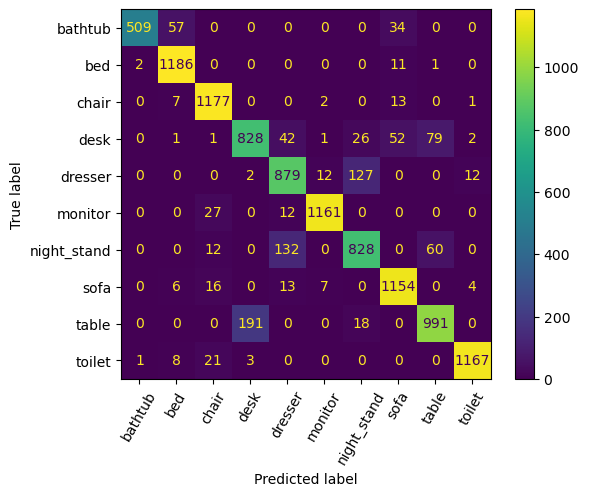


ACCURACY
Micro (global) accuracy: 0.9067547917366028
Accuracy for each class
	 bathtub :  0.84833336
	 bed :  0.98833334
	 chair :  0.98083335
	 desk :  0.8023256
	 dresser :  0.8517442
	 monitor :  0.9675
	 night_stand :  0.8023256
	 sofa :  0.96166664
	 table :  0.8258333
	 toilet :  0.9725


In [ ]:
metrics(predictions, labels, modelnet_classes, macro=False, each=True, weighted=False, F1=False)

### Metrics with voting


CONFUSION MATRIX


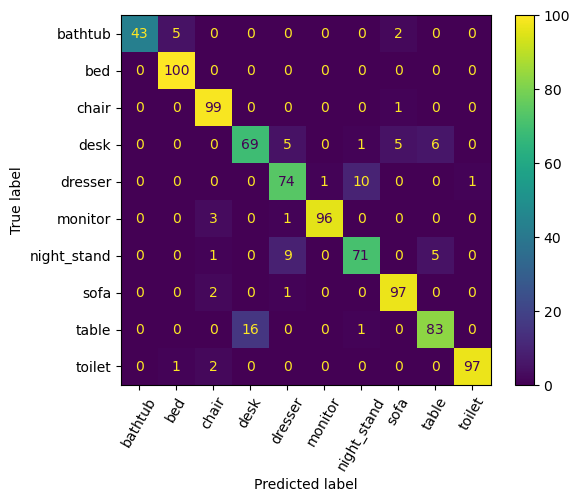


ACCURACY
Micro (global) accuracy: 0.9129955768585205
Macro accuracy: 0.9068371653556824


In [ ]:
predictions_vot = torch.tensor(predictions_vot)
labels_vot = torch.tensor(labels_vot)

metrics(predictions_vot, labels_vot, modelnet_classes, macro=True, each=False, weighted=False, F1=False)

## Reload saved network

Load files to continue training

In [ ]:
### Reload the network state
net_state_dict = torch.load('/content/drive/My Drive/Dataset/Saved_parameters/Orion_parameters_Desert_gorge_epoch39.torch')
# Update the network parameters
model.load_state_dict(net_state_dict)

# Reload the optimizer state
opt_state_dict = torch.load('/content/drive/My Drive/Dataset/Saved_parameters/Orion_optimizer_state_Desert_gorge_epoch39.torch')
optimizer.load_state_dict(opt_state_dict)

# Reload the scheduler state
#scheduler_state_dict = torch.load('scheduler_state.torch')
#scheduler.load_state_dict(scheduler_state_dict)

"# Reload the scheduler state\nscheduler_state_dict = torch.load('scheduler_state.torch')\nscheduler.load_state_dict(scheduler_state_dict)"

Load trained architecture

In [ ]:
#net_state_dict = torch.load('/content/drive/My Drive/Dataset/Saved_parameters/Orion_parameters_Pious_silence__epoch52.torch')
#net_state_dict = torch.load('/content/drive/My Drive/Progetto Andrea/Orion_parameters.torch')
net_state_dict = torch.load('Saved params/Final VoxNet & Orion/Orion_parameters_Swept_terrain__epoch57.torch', map_location=torch.device('cpu'))

if use_poseplan:
    num_rotations = poseplan
else:
    num_rotations = np.repeat(12, num_categories)
model = ORION(num_categories, num_rotations).to(device)
model.load_state_dict(net_state_dict)

<All keys matched successfully>

# Hyperparameters tuning

## VoxNet hyperparameters tuning

We performed the hyperparameter tuning on the VoxNet architecture. Since the Orion architecture is basically equal to the VoxNet one (apart from the last layer), we assumed that the optimal hyperparameters found in this section are a good choice also for the Orion network.  
We performed 3 steps of Optuna study, assigning different hyperparameters for each study.

$1^{st}$ study (optimization of gradient descent algorithm):
- optimizer (chose between SGD with momentum, RMSprop and Adam)
- learning rate
- weight decay ($L_2$ regularization)

$2^{nd}$ study (optimization of network parameters):
- dropout probability
- parameter of the Leaky ReLu activation function

$3^{rd}$ study:
- batch size

Results:
- Adam is the optimal optimizer, as it provides a faster convergence than SGD with momentum, while maintaining comparable results
- learning rate = weight_decay = $10^{-3}$
- dropout probability = 0.4
- the leaky ReLu parameter is not an important hyperparameter; we keep it fixed at value 0.1
- vary the batch size does not compromise results; we keep it fixed at value 32

In [ ]:
def objective(trial):

    batch_size = trial.suggest_int('batch_size', 10, 300)
    p_dropout = 0.41 #trial.suggest_float('p_dropout', 0, 0.5)
    val_relu = 0.022 #trial.suggest_float('val_relu', 0.01, 0.3)

    torch.manual_seed(0)
    model = VoxNet(num_categories, p_dropout, val_relu)
    model.apply(weights_init)

    optimizer_name = 'Adam' #trial.suggest_categorical('optimizer',['SGD','RMSprop','Adam'])
    learning_rate = 0.001 #trial.suggest_float('learning_rate', 1e-6, 1e-2, log=True)
    optimizer_weight_decay = 0.001  #trial.suggest_float('optimizer_weight_decay', 1e-5, 1e-1, log=True)
    #optimizer_momentum = trial.suggest_float('optimizer_momentum', 0, 0.9)
    #scheduler_step_size = 40000
    #scheduler_gamma = 0.1
    loss_fn = CrossEntropyLoss()
    epochs = 20

    if optimizer_name == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=optimizer_momentum, weight_decay=optimizer_weight_decay) #SGD with momentum and L2 regularization
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_step_size, gamma=scheduler_gamma) #learning rate decreases by a factor 10 each 40000 batches
    elif optimizer_name == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=optimizer_weight_decay)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=optimizer_weight_decay)

    model.to(device)
    best_val = np.inf

    wandb.init(project='Optimize batch_size',
           entity='nndl',
           config={
            "model": model,
            "batch size": batch_size,
            "epochs": epochs,
            "learning rate": learning_rate,
            "dropout": p_dropout,
            "val_relu": val_relu,
            #"momentum": optimizer_momentum,
            "weight decay": optimizer_weight_decay,
            #"scheduler step_size": scheduler_step_size,
            #"scheduler gamma": scheduler_gamma,
            "loss": loss_fn,
            "optimizer":  optimizer_name
            })
    wandb.watch(model, loss_fn, log="all")

    #print(f'params {[optimizer_name,learning_rate,optimizer_weight_decay,optimizer_momentum]}')
    print(f'params {batch_size}')

    train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)#, num_workers=os.cpu_count())
    val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False, drop_last=True)#, num_workers=os.cpu_count())

    for epoch in range(epochs):
        model.train()
        train_loss=[]
        for batch_x, batch_y in train_dataloader:
            batch_x = batch_x.reshape(batch_size,1,volume,volume,volume).to(device).float()
            batch_y = batch_y.to(device).float()

            y_pred = model(batch_x)
            loss = loss_fn(y_pred, batch_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if optimizer == 'SGD':
                scheduler.step()
            train_loss.append(loss.detach().cpu().numpy())
            del batch_x, batch_y, y_pred, loss
        train_loss = np.mean(train_loss)

        model.eval()
        with torch.no_grad():
            predictions, labels = [], []
            for batch_x, batch_y in val_dataloader:
                batch_x = batch_x.reshape(batch_size,1,volume,volume,volume).to(device).float()
                batch_y = batch_y.to(device).float()

                y_pred = model(batch_x)

                predictions.append(y_pred)
                labels.append(batch_y)
                del batch_x, batch_y, y_pred

            predictions = torch.cat(predictions, axis=0)
            labels = torch.cat(labels, axis=0)

            # Evaluate validation loss and accuracy
            val_loss = loss_fn(predictions, labels).detach().cpu().numpy()

        wandb.log({'epoch': epoch+1, 'train_loss': train_loss, 'val_loss': val_loss})

        if val_loss < best_val:
            best_val = val_loss

    wandb.finish()

    print(f'Validation loss = {best_val}')
    return best_val

In [ ]:
#storage = optuna.storages.InMemoryStorage()
storage = "sqlite:///db.sqlite3"
#storage = "sqlite:////content/drive/My Drive/Progetto Andrea/opt.db"

In [ ]:
study = optuna.create_study(storage=storage, direction="minimize", study_name='Opt_batch_Voxnet', load_if_exists=True)
study.optimize(objective, n_trials=15)

[I 2023-08-26 17:52:40,500] Using an existing study with name 'Opt_batch_Voxnet' instead of creating a new one.


params 248


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▃▃▄▃▃▃▃▂▂▂▂▁▁▂▂
epoch,20
train_loss,0.10146
val_loss,0.2171


[I 2023-08-26 17:58:37,658] Trial 1 finished with value: 0.18074771761894226 and parameters: {'batch_size': 248}. Best is trial 1 with value: 0.18074771761894226.
wandb: Currently logged in as: andreaperi (nndl). Use `wandb login --relogin` to force relogin


Validation loss = 0.18074771761894226


params 100


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▂▁▂▂▂▂▁▁▁▂▁▁▁▁
epoch,20
train_loss,0.10529
val_loss,0.18884


[I 2023-08-26 18:04:24,236] Trial 2 finished with value: 0.1822899430990219 and parameters: {'batch_size': 100}. Best is trial 1 with value: 0.18074771761894226.


Validation loss = 0.1822899430990219


params 205


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
val_loss,█▄▄▃▃▃▃▃▃▃▃▃▃▃▂▂▁▁▁▁
epoch,20
train_loss,0.10165
val_loss,0.20635


[I 2023-08-26 18:10:06,933] Trial 3 finished with value: 0.20056775212287903 and parameters: {'batch_size': 205}. Best is trial 1 with value: 0.18074771761894226.


Validation loss = 0.20056775212287903


params 19


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_loss,0.14847
val_loss,0.1831


[I 2023-08-26 18:18:03,457] Trial 4 finished with value: 0.17498579621315002 and parameters: {'batch_size': 19}. Best is trial 4 with value: 0.17498579621315002.


Validation loss = 0.17498579621315002


params 239


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▃▂▂▂▂▁▁▂▁▂▁▂▁▂▂▁
epoch,20
train_loss,0.09759
val_loss,0.19891


[I 2023-08-26 18:23:52,643] Trial 5 finished with value: 0.18553920090198517 and parameters: {'batch_size': 239}. Best is trial 4 with value: 0.17498579621315002.


Validation loss = 0.18553920090198517


params 151


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▅▄▄▁▁▁▂▂▂▁▂▁▁▁▁▁
epoch,20
train_loss,0.10119
val_loss,0.18531


[I 2023-08-26 18:29:37,020] Trial 6 finished with value: 0.18531478941440582 and parameters: {'batch_size': 151}. Best is trial 4 with value: 0.17498579621315002.


Validation loss = 0.18531478941440582


params 70


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▃▃▃▂▁▁▁▁▁▂▁▁▁▁▂▁▁▁
epoch,20
train_loss,0.10945
val_loss,0.19167


[I 2023-08-26 18:35:38,126] Trial 7 finished with value: 0.188869446516037 and parameters: {'batch_size': 70}. Best is trial 4 with value: 0.17498579621315002.


Validation loss = 0.188869446516037


params 212


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
val_loss,█▄▃▃▃▃▃▂▃▃▂▃▂▂▃▂▁▁▁▁
epoch,20
train_loss,0.10275
val_loss,0.20602


[I 2023-08-26 18:41:24,283] Trial 8 finished with value: 0.19797596335411072 and parameters: {'batch_size': 212}. Best is trial 4 with value: 0.17498579621315002.


Validation loss = 0.19797596335411072


params 249


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▄▄▄▄▄▂▂▂▂▂▁▂▂▁▂▁▁
epoch,20
train_loss,0.10087
val_loss,0.18371


[I 2023-08-26 18:47:09,569] Trial 9 finished with value: 0.1782550811767578 and parameters: {'batch_size': 249}. Best is trial 4 with value: 0.17498579621315002.


Validation loss = 0.1782550811767578


params 239


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁
val_loss,█▆▆▆▆▆▅▂▃▃▃▃▃▃▃▂▁▂▁▁
epoch,20
train_loss,0.09813
val_loss,0.20526


[I 2023-08-26 18:52:58,956] Trial 10 finished with value: 0.1903977245092392 and parameters: {'batch_size': 239}. Best is trial 4 with value: 0.17498579621315002.


Validation loss = 0.1903977245092392


params 10


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▂▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁
epoch,20
train_loss,0.18062
val_loss,0.19953


[I 2023-08-26 19:02:33,452] Trial 11 finished with value: 0.18485593795776367 and parameters: {'batch_size': 10}. Best is trial 4 with value: 0.17498579621315002.


Validation loss = 0.18485593795776367


params 281


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
val_loss,█▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁
epoch,20
train_loss,0.10269
val_loss,0.19249


[I 2023-08-26 19:08:25,734] Trial 12 finished with value: 0.18312996625900269 and parameters: {'batch_size': 281}. Best is trial 4 with value: 0.17498579621315002.


Validation loss = 0.18312996625900269


params 155


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▃▂▁▁▁▂▂▁▂▁▁▁▁▁▁▂▂
epoch,20
train_loss,0.10281
val_loss,0.2128


[I 2023-08-26 19:14:14,977] Trial 13 finished with value: 0.19595326483249664 and parameters: {'batch_size': 155}. Best is trial 4 with value: 0.17498579621315002.


Validation loss = 0.19595326483249664


params 17


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▁▂▁▃▁▁▁▂▁▁▁▁▁
epoch,20
train_loss,0.15503
val_loss,0.19467


[I 2023-08-26 19:22:28,443] Trial 14 finished with value: 0.18732576072216034 and parameters: {'batch_size': 17}. Best is trial 4 with value: 0.17498579621315002.


Validation loss = 0.18732576072216034


params 98


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▆▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
train_loss,0.10514
val_loss,0.17968


[I 2023-08-26 19:28:26,902] Trial 15 finished with value: 0.17967922985553741 and parameters: {'batch_size': 98}. Best is trial 4 with value: 0.17498579621315002.


Validation loss = 0.17967922985553741


In [ ]:
best_trial = study.best_trial
print(f'Best validation accuracy = {best_trial.value:.3f} \n with params = {best_trial.params}')

Best validation accuracy = 0.175 
 with params = {'batch_size': 19}


Open the Optuna dashboard

In [ ]:
port = 8081
app = wsgi(storage)
httpd = make_server("localhost", port, app)
thread = threading.Thread(target=httpd.serve_forever)
thread.start()

In [ ]:
output.serve_kernel_port_as_window(port, path='/dashboard/')

<IPython.core.display.Javascript object>

## Orion loss hyperparameter tuning

The loss used in the training phase of the Orion architecture is defined as:

$$ \mathcal{L} = (1-\gamma)\mathcal{L}_C + \gamma\mathcal{L}_O $$

where $\mathcal{L}_C$ and $\mathcal{L}_O$ are cross-entropy losses acting respectively on category and rotation predictions.

In this subsection, we operate an Optuna study to find the value of $\gamma$ which minimize $\mathcal{L}_C$ in the validation set.

We find that 0.5 is a good value for $\gamma$.

In [ ]:
# Network initialization
if use_poseplan:
    num_rotations = poseplan
else:
    num_rotations = np.repeat(12, num_categories)
model = ORION(num_categories, num_rotations)
model.to(device)

learning_rate = 0.001
optimizer_weight_decay = 0.001
epochs = 30

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=optimizer_weight_decay)
loss_cat = CrossEntropyLoss()
loss_rot = CrossEntropyLoss()

def loss_total(cat, rot, gamma):
    return (1-gamma)*cat + gamma*rot

In [ ]:
def objective(trial):

    torch.manual_seed(0)
    model.apply(weights_init)

    gamma_loss = trial.suggest_float('gamma_loss', 0, 1)

    best_val = np.inf

    wandb.init(project='Optimize gamma_loss',
           entity='nndl',
           config={
            "model": model,
            "epochs": epochs,
            "learning rate": learning_rate,
            "weight decay": optimizer_weight_decay,
            "gamma_loss": gamma_loss
            })
    wandb.watch(model, log="all")

    print(f'params {gamma_loss}')

    for epoch in range(epochs):
        model.train()
        train_loss, train_loss_cat, train_loss_rot = [], [], []

        for batch_x, batch_y, batch_rot in train_dataloader:
            batch_x = batch_x.reshape(batch_size,1,volume,volume,volume).to(device).float()
            batch_y = batch_y.to(device).float()
            batch_rot = batch_rot.to(device).float()

            y_pred = model(batch_x)

            y_pred_cat = y_pred[:,:num_categories]
            lossc = loss_cat(y_pred_cat, batch_y)
            class_ = batch_y.softmax(axis=1).detach().cpu().numpy().argmax(axis=1)

            y_pred_rot = y_pred[:,num_categories:]
            batch_rot_eff = torch.zeros((batch_size,num_rotations.sum())).to(device)
            for i in range(batch_size):
                batch_rot_eff[i, sum(num_rotations[:class_[i]]) : sum(num_rotations[:class_[i]]) + num_rotations[class_[i]]] = batch_rot[i,:num_rotations[class_[i]]]
            batch_rot = batch_rot_eff
            del batch_rot_eff

            lossr = loss_rot(y_pred_rot, batch_rot)
            loss = loss_total(lossc, lossr, gamma_loss)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Save train loss for this batch
            train_loss.append(loss.detach().cpu().numpy())
            train_loss_cat.append(lossc.detach().cpu().numpy())
            train_loss_rot.append(lossr.detach().cpu().numpy())

            del batch_x, batch_y, batch_rot, y_pred, y_pred_cat, lossc, class_, y_pred_rot, lossr, loss

        # Average train loss
        train_loss, train_loss_cat, train_loss_rot = np.mean(train_loss), np.mean(train_loss_cat), np.mean(train_loss_rot)

        model.eval()
        with torch.no_grad():
            predictions_cat, predictions_rot, labels_cat, labels_rot = [], [], [], []
            for batch_x, batch_y, batch_rot in val_dataloader:
                data_shape = batch_x.shape
                batch_x = batch_x.reshape(data_shape[0],1,volume,volume,volume).to(device).float()
                batch_y = batch_y.to(device).float()
                batch_rot = batch_rot.to(device).float()

                y_pred = model(batch_x)

                y_pred_cat = y_pred[:,:num_categories]
                predictions_cat.append(y_pred_cat)
                class_ = batch_y.softmax(axis=1).detach().cpu().numpy().argmax(axis=1)

                y_pred_rot = y_pred[:,num_categories:]
                batch_rot_eff = torch.zeros((batch_size,num_rotations.sum())).to(device)
                for i in range(batch_size):
                    batch_rot_eff[i, sum(num_rotations[:class_[i]]) : sum(num_rotations[:class_[i]]) + num_rotations[class_[i]]] = batch_rot[i,:num_rotations[class_[i]]]
                batch_rot = batch_rot_eff
                del batch_rot_eff

                predictions_rot.append(y_pred_rot)

                labels_cat.append(batch_y)
                labels_rot.append(batch_rot)

                del batch_x, batch_y, batch_rot, y_pred, y_pred_cat, class_, y_pred_rot

            predictions_cat = torch.cat(predictions_cat, axis=0)
            predictions_rot = torch.cat(predictions_rot, axis=0)
            labels_cat = torch.cat(labels_cat, axis=0)
            labels_rot = torch.cat(labels_rot, axis=0)

            # Evaluate validation loss and accuracy
            val_loss_cat = loss_cat(predictions_cat, labels_cat)
            val_loss_rot = loss_rot(predictions_rot, labels_rot)
            val_loss = loss_total(val_loss_cat, val_loss_rot, gamma_loss)

            val_loss = val_loss.detach().cpu().numpy()

        wandb.log({'epoch': epoch+1, 'train_loss': train_loss, 'train_loss_cat': train_loss_cat, 'train_loss_rot': train_loss_rot,
                  'val_loss': val_loss, 'val_loss_cat': val_loss_cat, 'val_loss_rot': val_loss_rot})

        if val_loss < best_val:
            best_val = val_loss
            best_val_cat = val_loss_cat

    wandb.finish()

    print(f'Validation loss = {best_val}')
    print(f'Validation loss (category) = {best_val_cat}')
    return best_val_cat

In [ ]:
storage = "sqlite:///db.sqlite3"
study = optuna.create_study(storage=storage, direction="minimize", study_name='Opt_gammaloss_Orion', load_if_exists=True)
study.optimize(objective, n_trials=15)

In [ ]:
wandb.finish()

In [ ]:
best_trial = study.best_trial
print(f'Best validation accuracy = {best_trial.value:.3f} \n with params = {best_trial.params}')

# (Macro-averaged) Precision-Recall Curves

## Load model and perform classification

VoxNet

In [ ]:
#net_state_dict = torch.load('/content/drive/My Drive/Dataset/Saved_parameters/Voxnet_parameters_Valian_wind__epoch25.torch')
net_state_dict = torch.load('Saved params/Final VoxNet & Orion/Voxnet_parameters_Dark_pond__epoch37.torch', map_location=torch.device('cpu'))

model = VoxNet(num_categories).to(device)
model.load_state_dict(net_state_dict)

<All keys matched successfully>

In [ ]:
model.eval()
with torch.no_grad():
    predictions_vot, labels_vot, prob, prob_oh = [], [], [], []
    for batch_x, batch_y in tqdm(test_dataloader):
        batch_x = batch_x.reshape(12,1,volume,volume,volume).to(device).float()
        batch_y = batch_y.to(device).float()

        y_pred = model(batch_x)

        y_pred_cat = y_pred[:,:num_categories]
        y_pred_cat = torch.sum(y_pred_cat.softmax(axis=1), 0)
        predictions_vot.append(y_pred_cat.detach().cpu().numpy().argmax())
        labels_vot.append(batch_y[0].detach().cpu().numpy().argmax())
        ps = y_pred_cat.detach().cpu().numpy()/12
        prob_oh.append(ps)
        prob.append(max(ps))

        del batch_x, batch_y, y_pred, y_pred_cat

100%|████████████████████████████████████████████████████████████████████████████████| 908/908 [00:28<00:00, 32.06it/s]


Orion

In [ ]:
net_state_dict = torch.load('Saved params/Final VoxNet & Orion/Orion_parameters_Sage_feather__epoch51.torch', map_location=torch.device('cpu'))

if use_poseplan:
    num_rotations = poseplan
else:
    num_rotations = np.repeat(12, num_categories)
model = ORION(num_categories, num_rotations).to(device)
model.load_state_dict(net_state_dict)

<All keys matched successfully>

In [ ]:
model.eval()
with torch.no_grad():
    predictions_vot, labels_vot, prob, prob_oh = [], [], [], []
    for batch_x, batch_y, batch_rot in tqdm(test_dataloader):
        batch_x = batch_x.reshape(12,1,volume,volume,volume).to(device).float()
        batch_y = batch_y.to(device).float()
        batch_rot = batch_rot.to(device).float()

        y_pred = model(batch_x)

        y_pred_cat = y_pred[:,:num_categories]
        y_pred_cat = torch.sum(y_pred_cat.softmax(axis=1), 0)
        predictions_vot.append(y_pred_cat.detach().cpu().numpy().argmax())
        labels_vot.append(batch_y[0].detach().cpu().numpy().argmax())
        ps = y_pred_cat.detach().cpu().numpy()/12
        prob_oh.append(ps)
        prob.append(max(ps))

        del batch_x, batch_y, batch_rot, y_pred, y_pred_cat

100%|████████████████████████████████████████████████████████████████████████████████| 908/908 [00:30<00:00, 29.98it/s]


## Compute Precision-Recall Curve

In [ ]:
res = pd.DataFrame({'pred':predictions_vot, 'label':labels_vot, 'prob':prob})

In [ ]:
res.head()

,pred,label,prob
0,0,0,0.999944
1,0,0,0.999937
2,0,0,0.999944
3,0,0,0.999943
4,1,0,0.936203


In [ ]:
res.describe()

,pred,label,prob
count,908.000000,908.000000,908.000000
mean,4.750000,4.755507,0.986210
std,2.814408,2.800166,0.061986
min,0.000000,0.000000,0.396018
25%,2.000000,2.000000,0.999611
50%,5.000000,5.000000,0.999939
75%,7.000000,7.000000,0.999944
max,9.000000,9.000000,0.999945


In [ ]:
res['prob'].quantile(0.01)

0.6095926773548126

Compute precision and recall for different thresholds

In [ ]:
t1, t2, t3, t4, t5 = list(np.arange(0.3, 0.99, 0.01)), list(np.arange(0.99, 0.99905, 1e-4)), list(np.arange(0.99905, 0.99950, 2e-5)), list(np.arange(0.99950, 0.9998, 2e-7)), list(np.arange(0.999939, 0.999945, 5e-8))
theta = t1 + t2 + t3 + t4 + t5

precision, recall = np.zeros(len(theta)), np.zeros(len(theta))

for i in range(len(theta)):
    prec_t, rec_t = [], []
    for C in range(num_categories):
        filter_C = res[res['label']==C]                          # only samples with label C
        filter_CC = filter_C[filter_C['pred']==C]                # samples with label C and prediction C
        TP = len(filter_CC[filter_CC['prob']>theta[i] ] )        # True positive
        FP = len(res[(res['prob']>theta[i]) & (res['label']!=C) & (res['pred']==C) ] ) #False positive

        if TP==0 and FP==0:
            prec_t.append(1)
        else:
            prec_t.append(TP/(TP+FP))

        rec_t.append(TP/len(filter_C))

    precision[i] = np.mean(prec_t)
    recall[i] = np.mean(rec_t)

Compute Average Precision

In [ ]:
average_precision = AveragePrecision(task="multiclass", num_classes=num_categories)
AP = average_precision(torch.tensor(np.array(prob_oh)), torch.tensor(np.array(labels_vot))).item()
print(f"AP = {AP:.4f}")

AP = 0.9648


Save precision and recall results in a CSV file

In [ ]:
with open('Prec_Rec_curves/prec-rec_Orion_MN10.csv', 'w') as f:
    writer = csv.writer(f)
    for row in zip(precision,recall):
        writer.writerow(row)

### Load and plot results

In [ ]:
V10 = pd.read_csv('Prec_Rec_curves/prec-rec_VoxNet_MN10.csv', header=None, names=['prec','rec'])
V40 = pd.read_csv('Prec_Rec_curves/prec-rec_VoxNet_MN40.csv', header=None, names=['prec','rec'])
O10 = pd.read_csv('Prec_Rec_curves/prec-rec_Orion_MN10.csv', header=None, names=['prec','rec'])
O40 = pd.read_csv('Prec_Rec_curves/Orion_MN40.csv', header=None, names=['prec','rec'])

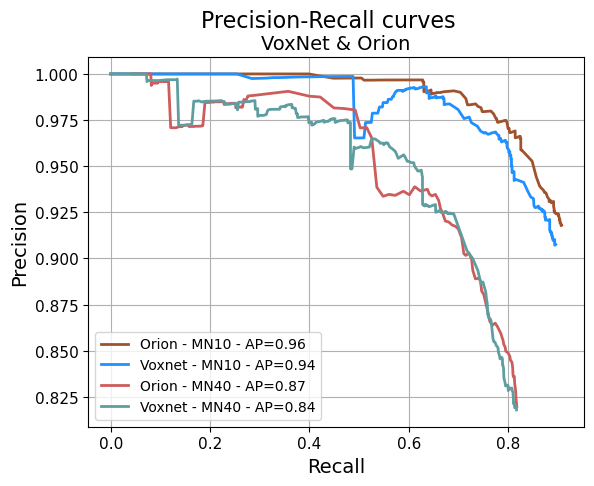

In [ ]:
plt.plot(O10['rec'],O10['prec'], 'sienna', lw=2, label='Orion - MN10 - AP=0.96')
plt.plot(V10['rec'],V10['prec'], 'dodgerblue', lw=2, label='Voxnet - MN10 - AP=0.94')
plt.plot(O40['rec'],O40['prec'], 'indianred', lw=2, label='Orion - MN40 - AP=0.87')
plt.plot(V40['rec'],V40['prec'], 'cadetblue', lw=2, label='Voxnet - MN40 - AP=0.84')
plt.legend()
plt.suptitle('Precision-Recall curves', fontsize=16)
plt.title('VoxNet & Orion', fontsize=14)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid()